# PD Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [2]:
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')
import matplotlib_venn
from scipy import stats
import scipy.stats as stats
from sklearn import cross_validation
from collections import Counter

## Preprocessing

In [3]:
# file directories
workingDirectory = '/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis/'
genomes = ['hg38','mm10']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath= workingDirectory + '/tag_directories/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'


os.chdir(workingDirectory)

strains = []
treatments = []
owners = []
dates = []
sampleNames = []
for tagDir in os.listdir(tagDirPath):

    metaDataTokens = tagDir.split('_')
    sampleNames.append(tagDir)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip().split('-')[0]
    treatment = metaDataTokens[2].strip()
    owner = metaDataTokens[3].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  sampleNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = '-'.join([x for x in t.split('-')][:-1])
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

### read in log files ###

# create data frame summarizing mapping quality logs
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_sampleNames =[]
# from tagInfo.txt
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []

for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
    rootName = logFile
    for gen in genomes:
        rootName = rootName.replace('.' + gen + '.star.log','')
    totalReads = int(data[5].split()[5])
    uniquelyMappedReads = int(data[8].split()[5])
    multiMappedReads = int(data[23].split()[8])
    unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads

    _sampleNames.append(rootName)
    _totalReads.append(totalReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)
for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_sampleNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']


summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics.tsv', sep='\t', index=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:127: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [4]:
clinical_frame = pd.read_csv('clinical_data_17-06-23.txt',sep='\t')
clinical_frame.index = clinical_frame['RNA-seq'].values
clinical_frame = clinical_frame[[x for x in clinical_frame.columns if not 'Unnamed' in x]]

clinical_frame['IL-6'] = [2.0 if x == '<2,0' else float(x) for x in clinical_frame['IL-6']]
clinical_frame['IL-10'] = [5.0 if x == '<5,0' else float(x) for x in clinical_frame['IL-10']]
clinical_frame['CRP'] = [0.0 if x == '<0,2' else float(x) for x in clinical_frame['CRP']]


## Mapping Quality Control

### Plot Distributions of Mapping Statistics

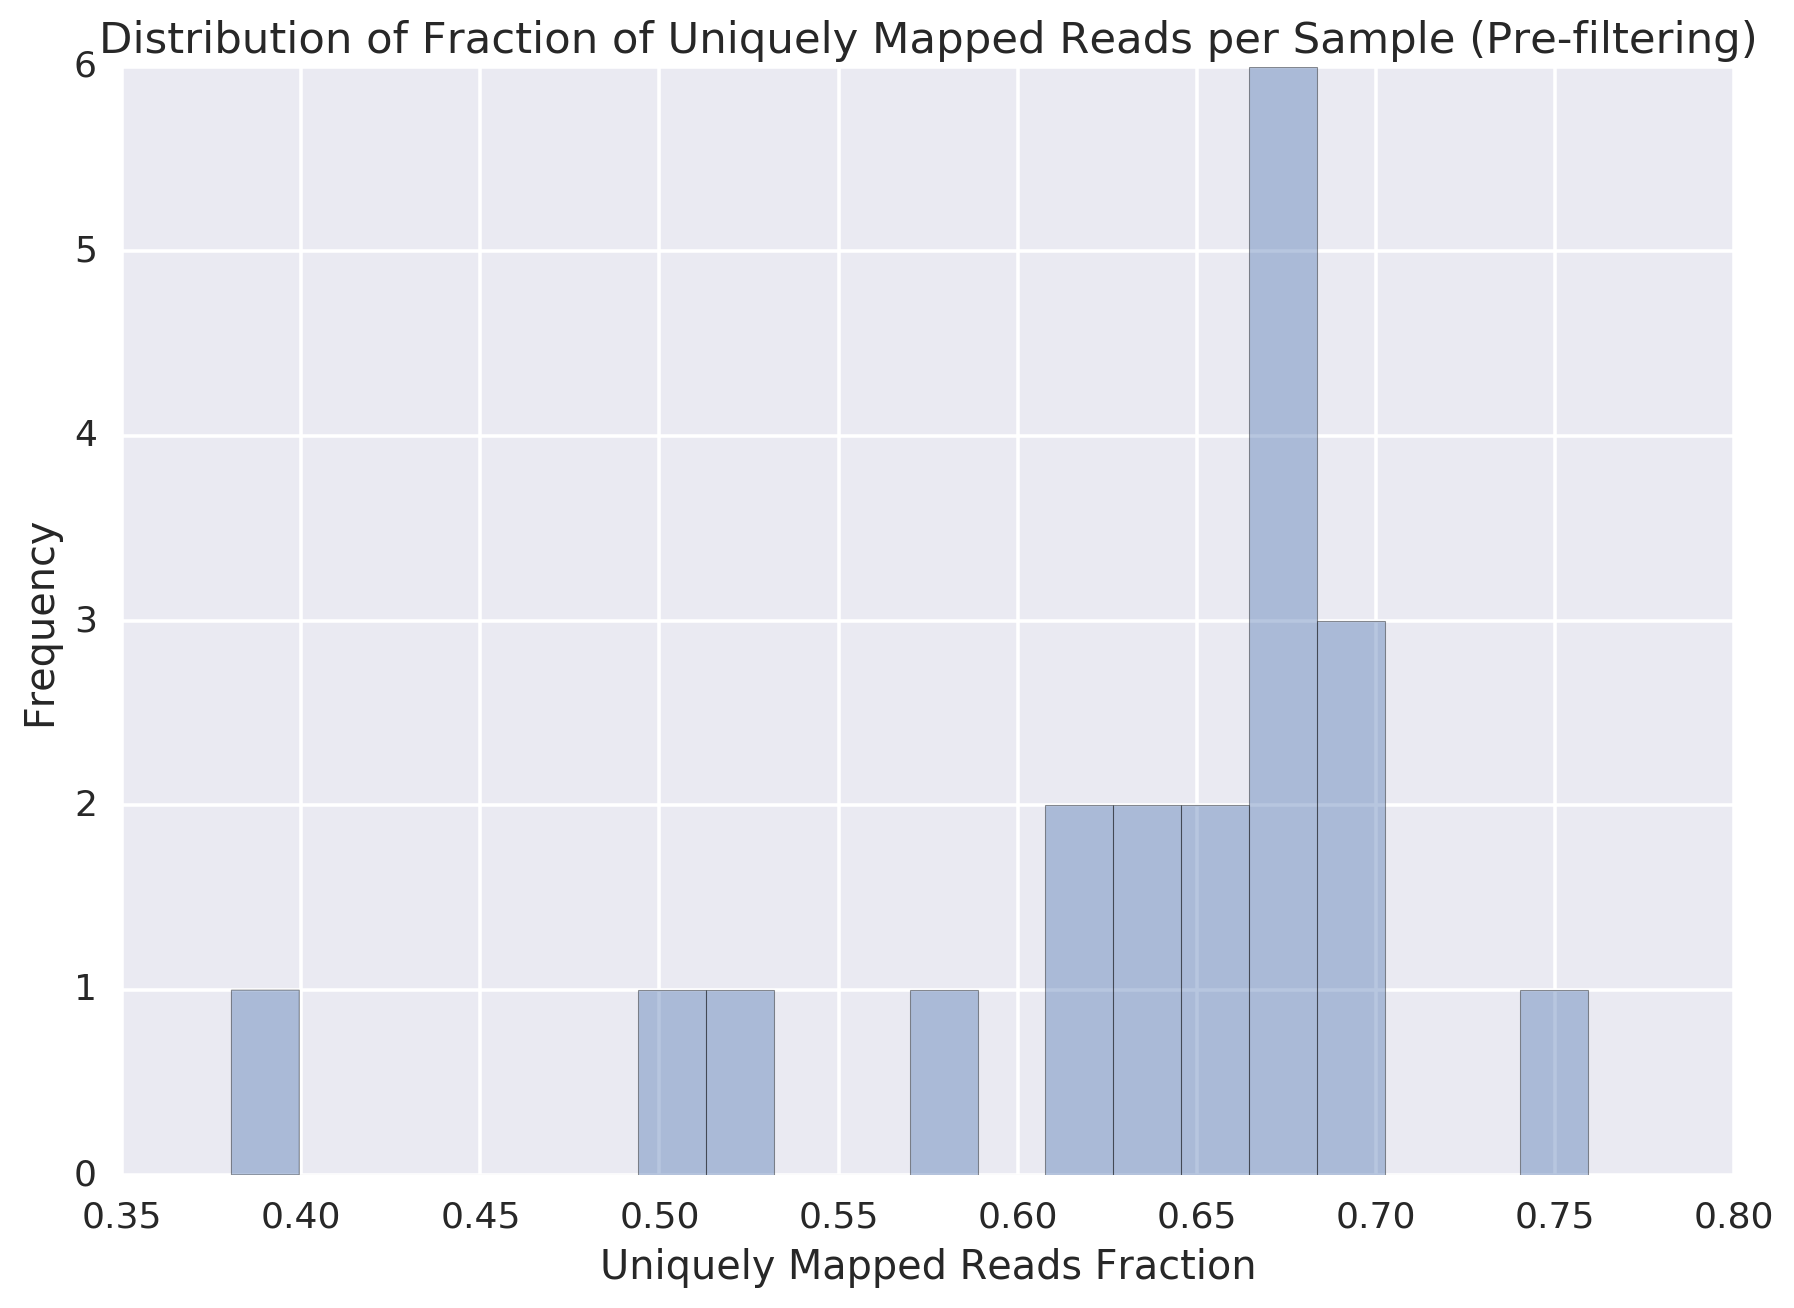

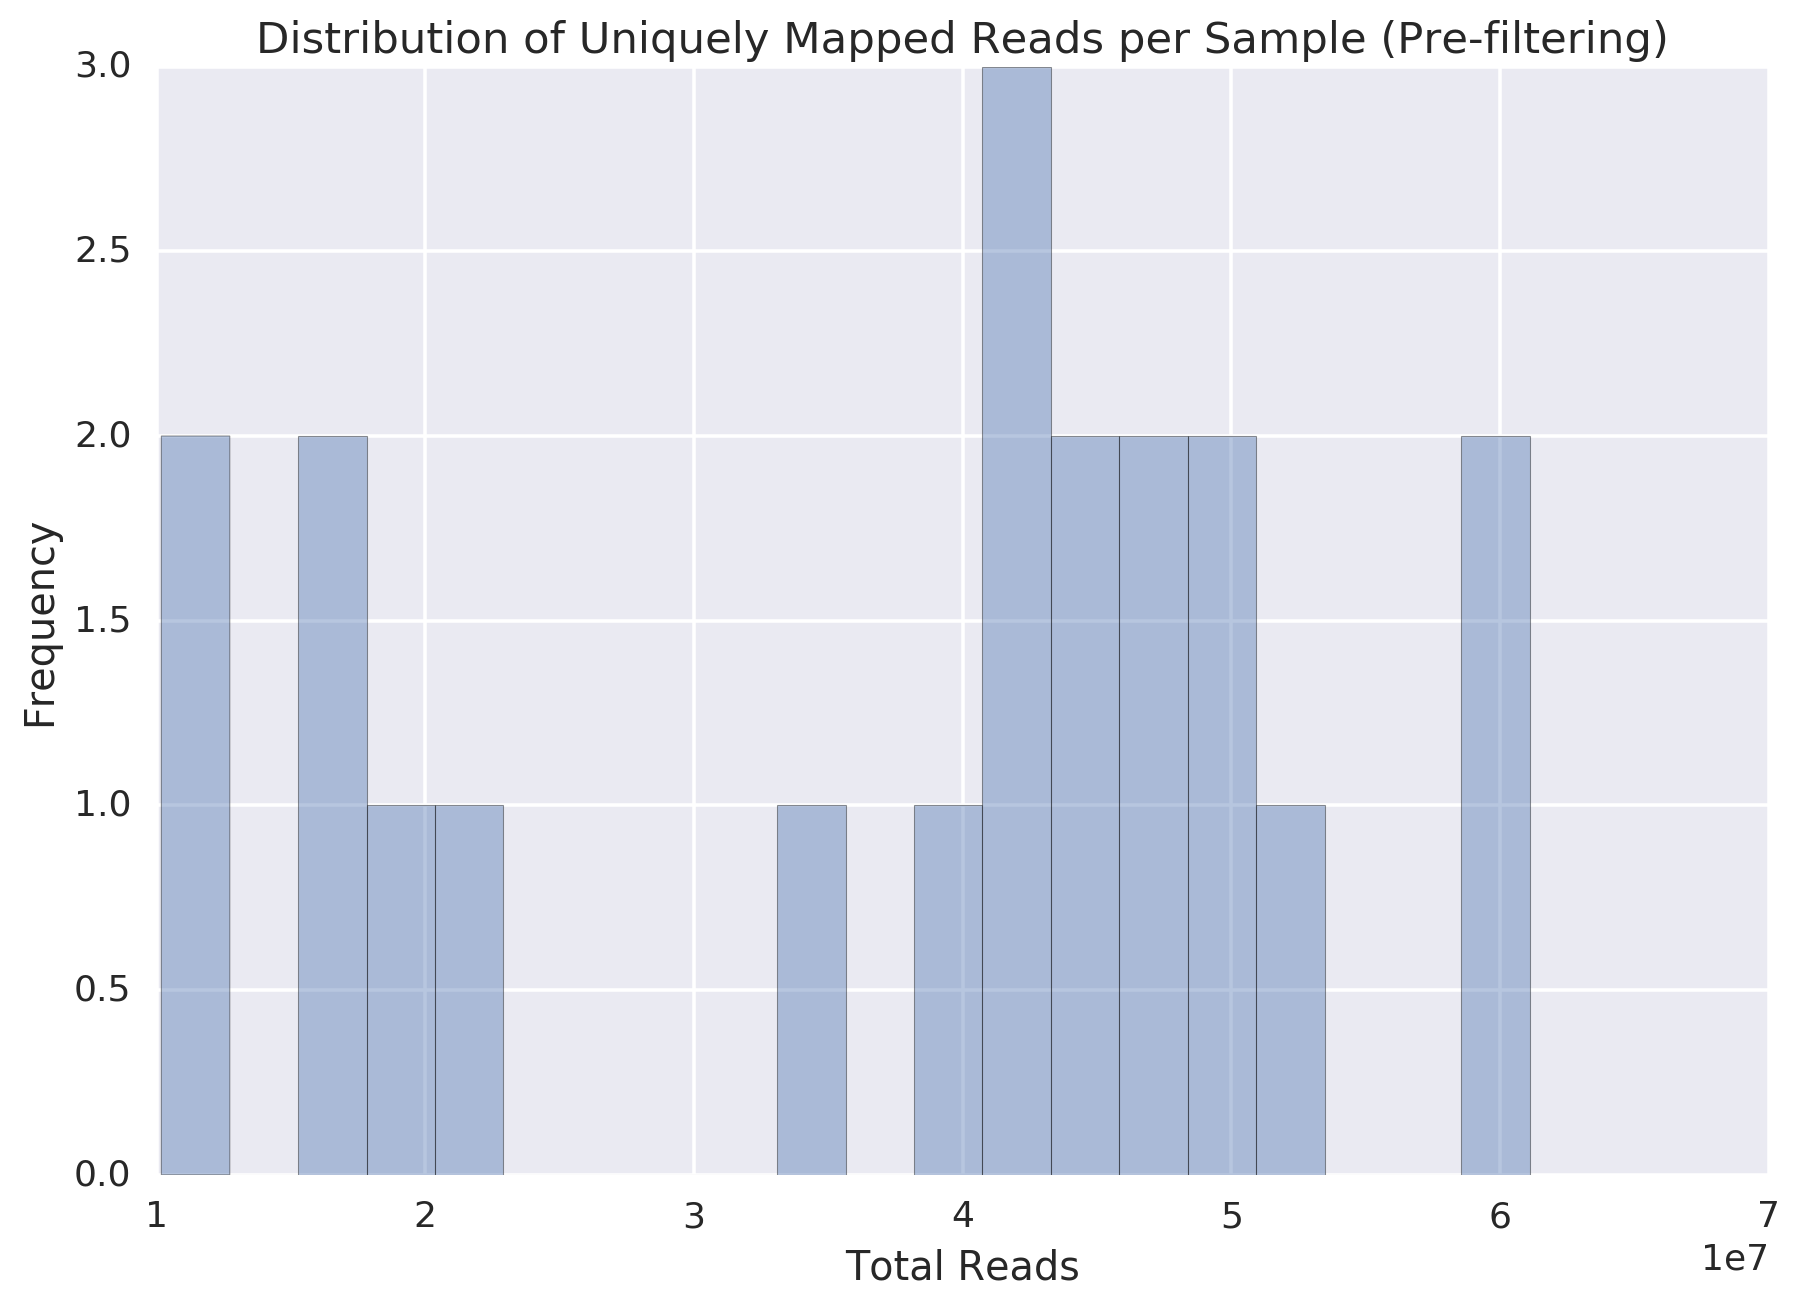

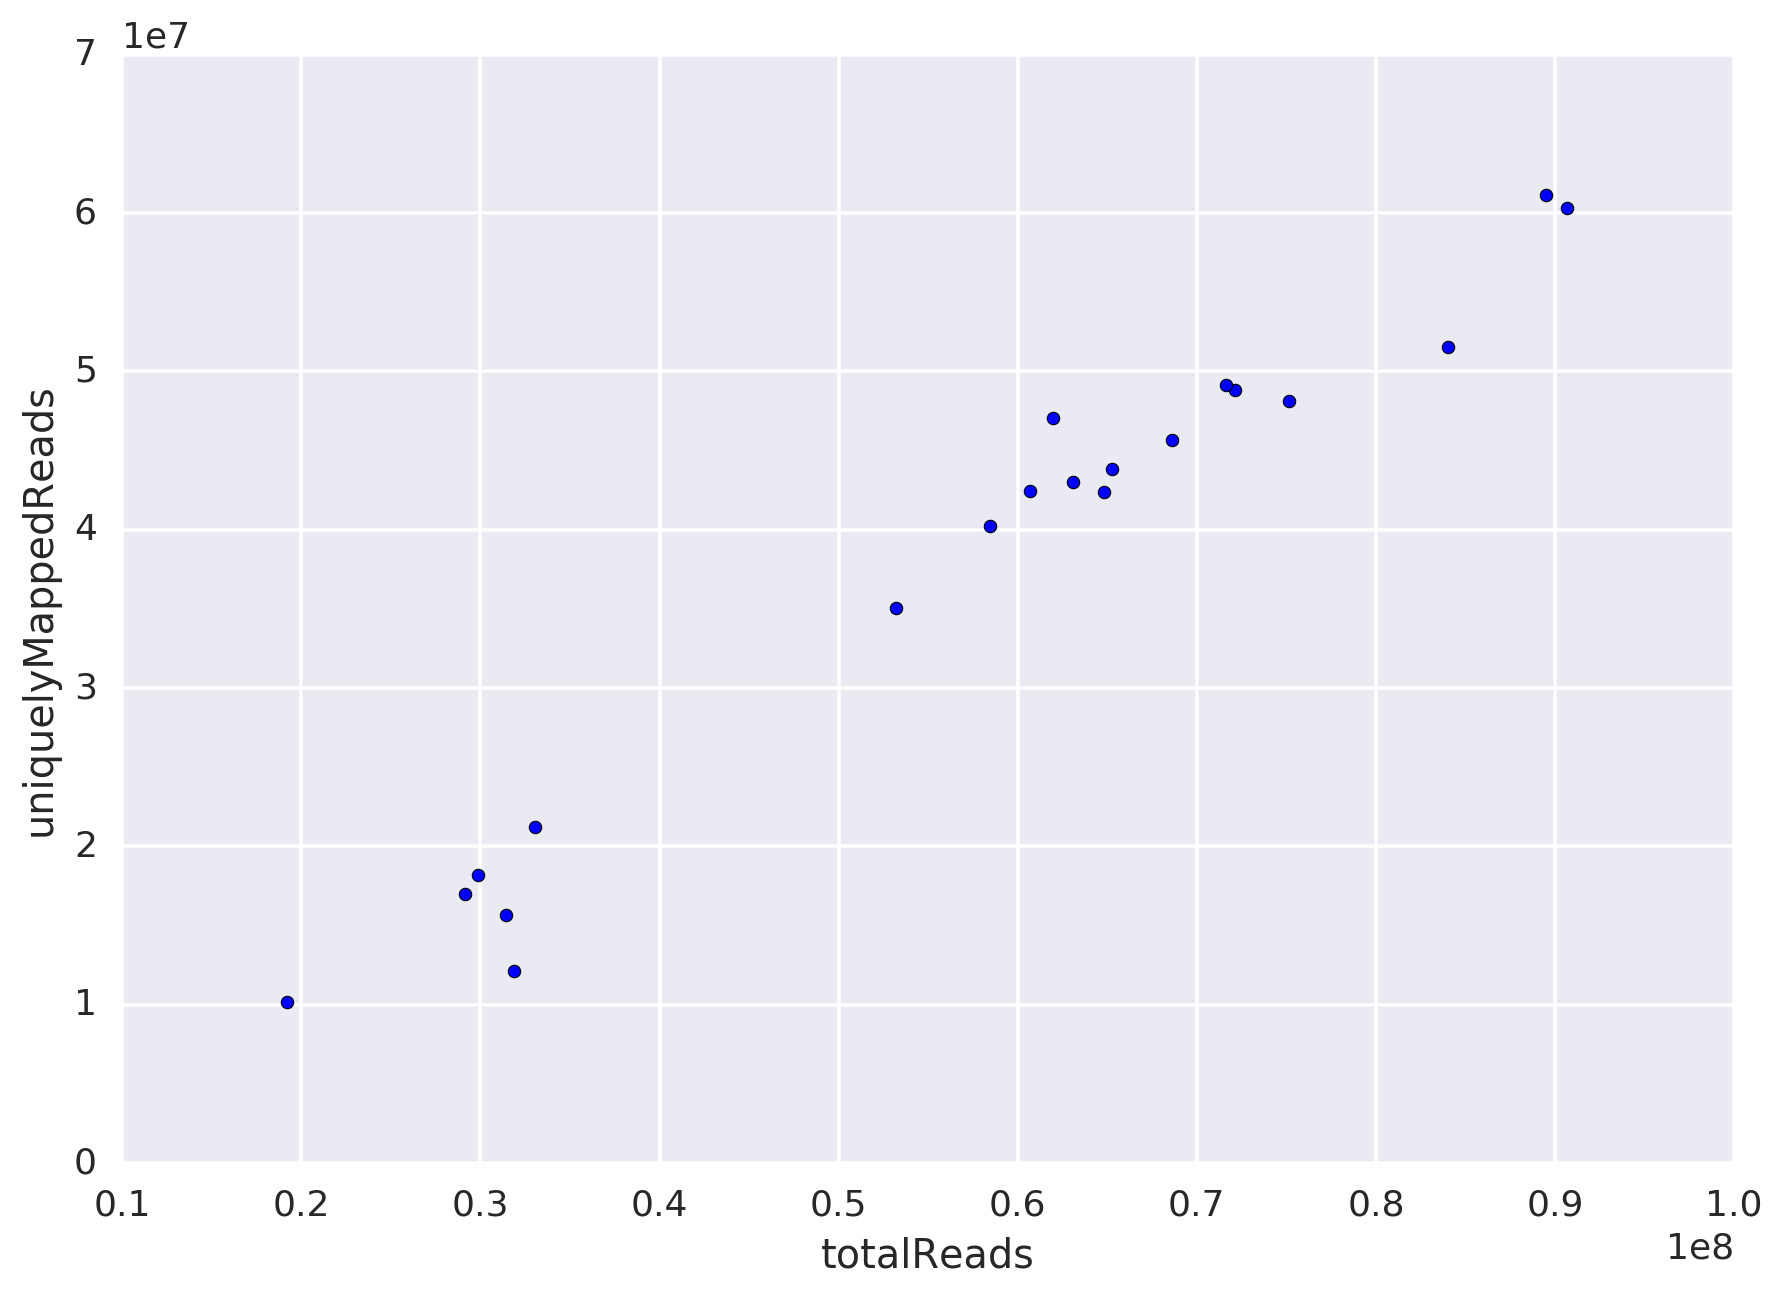

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


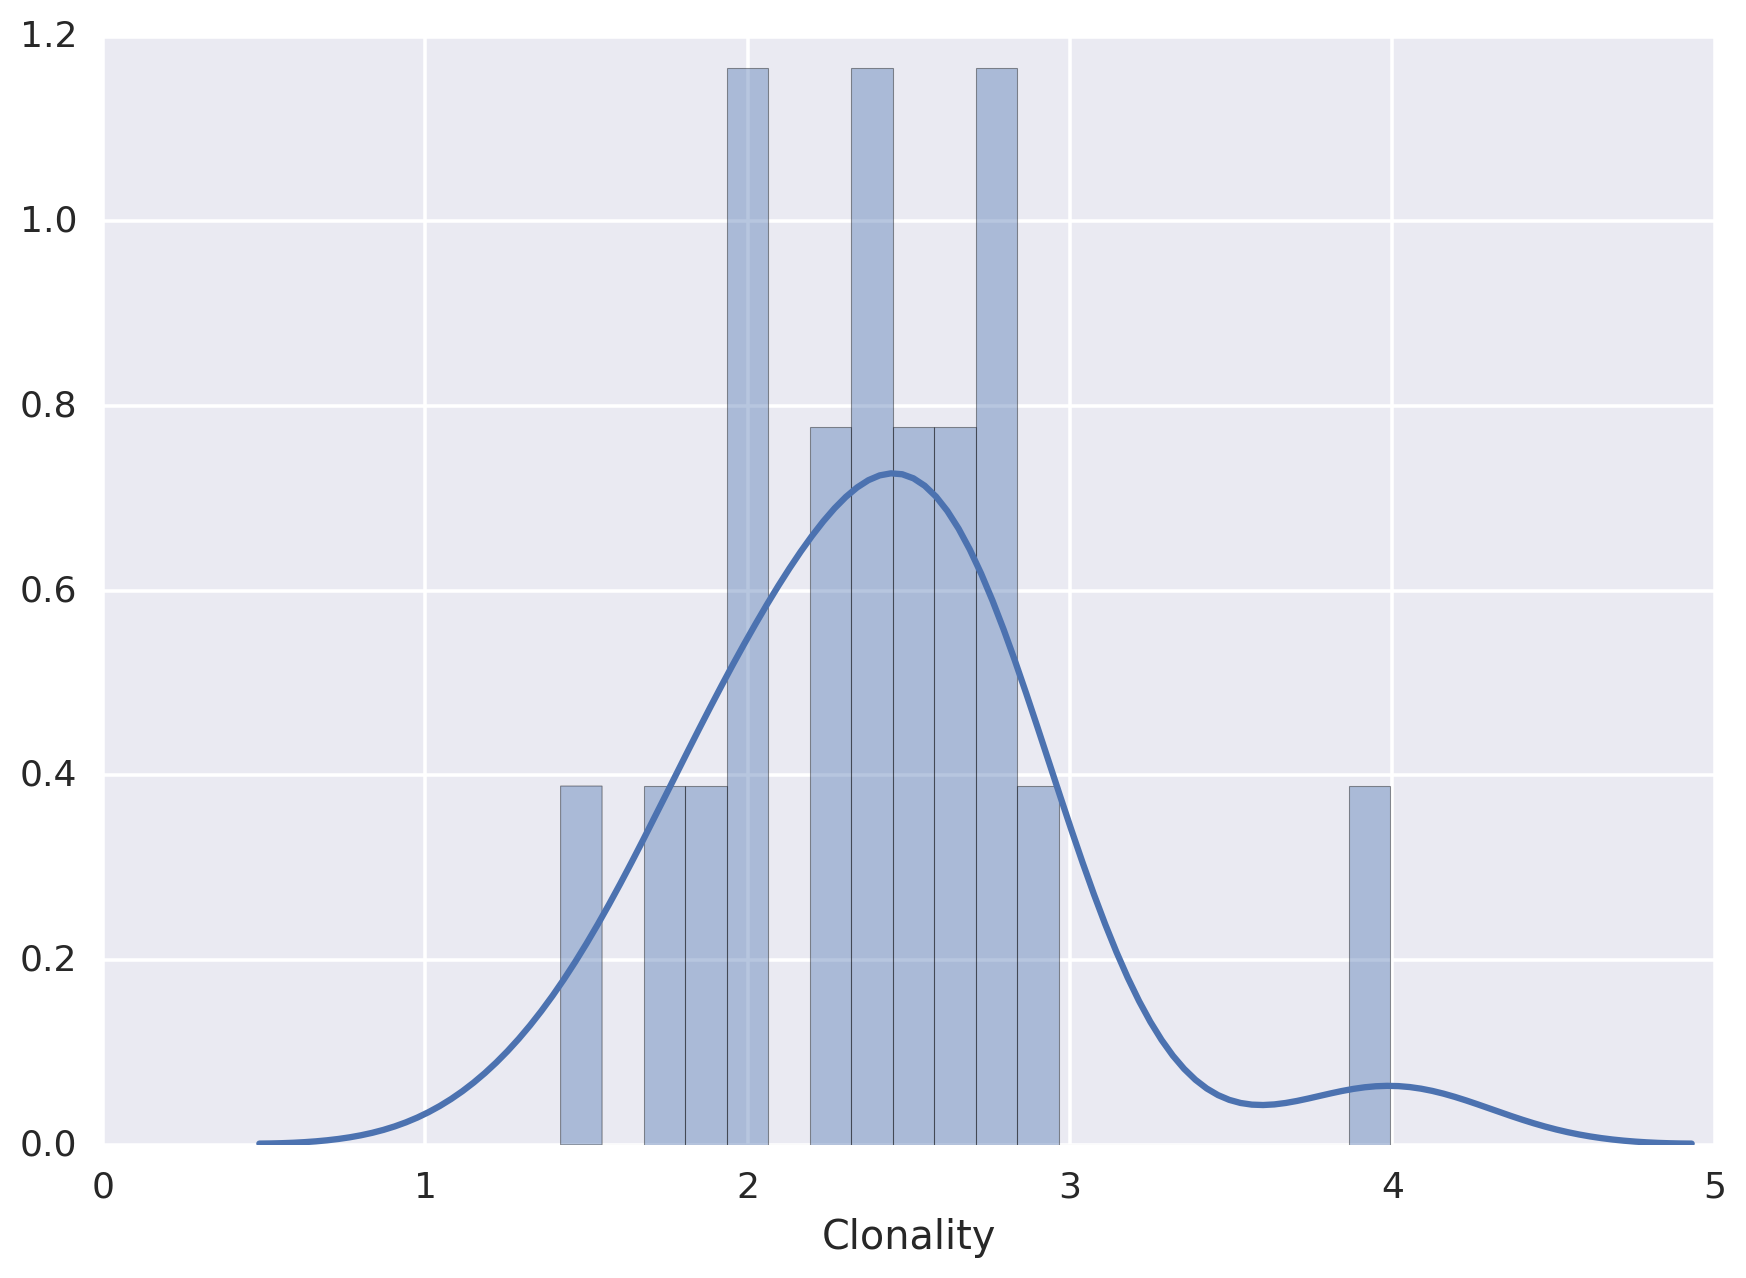

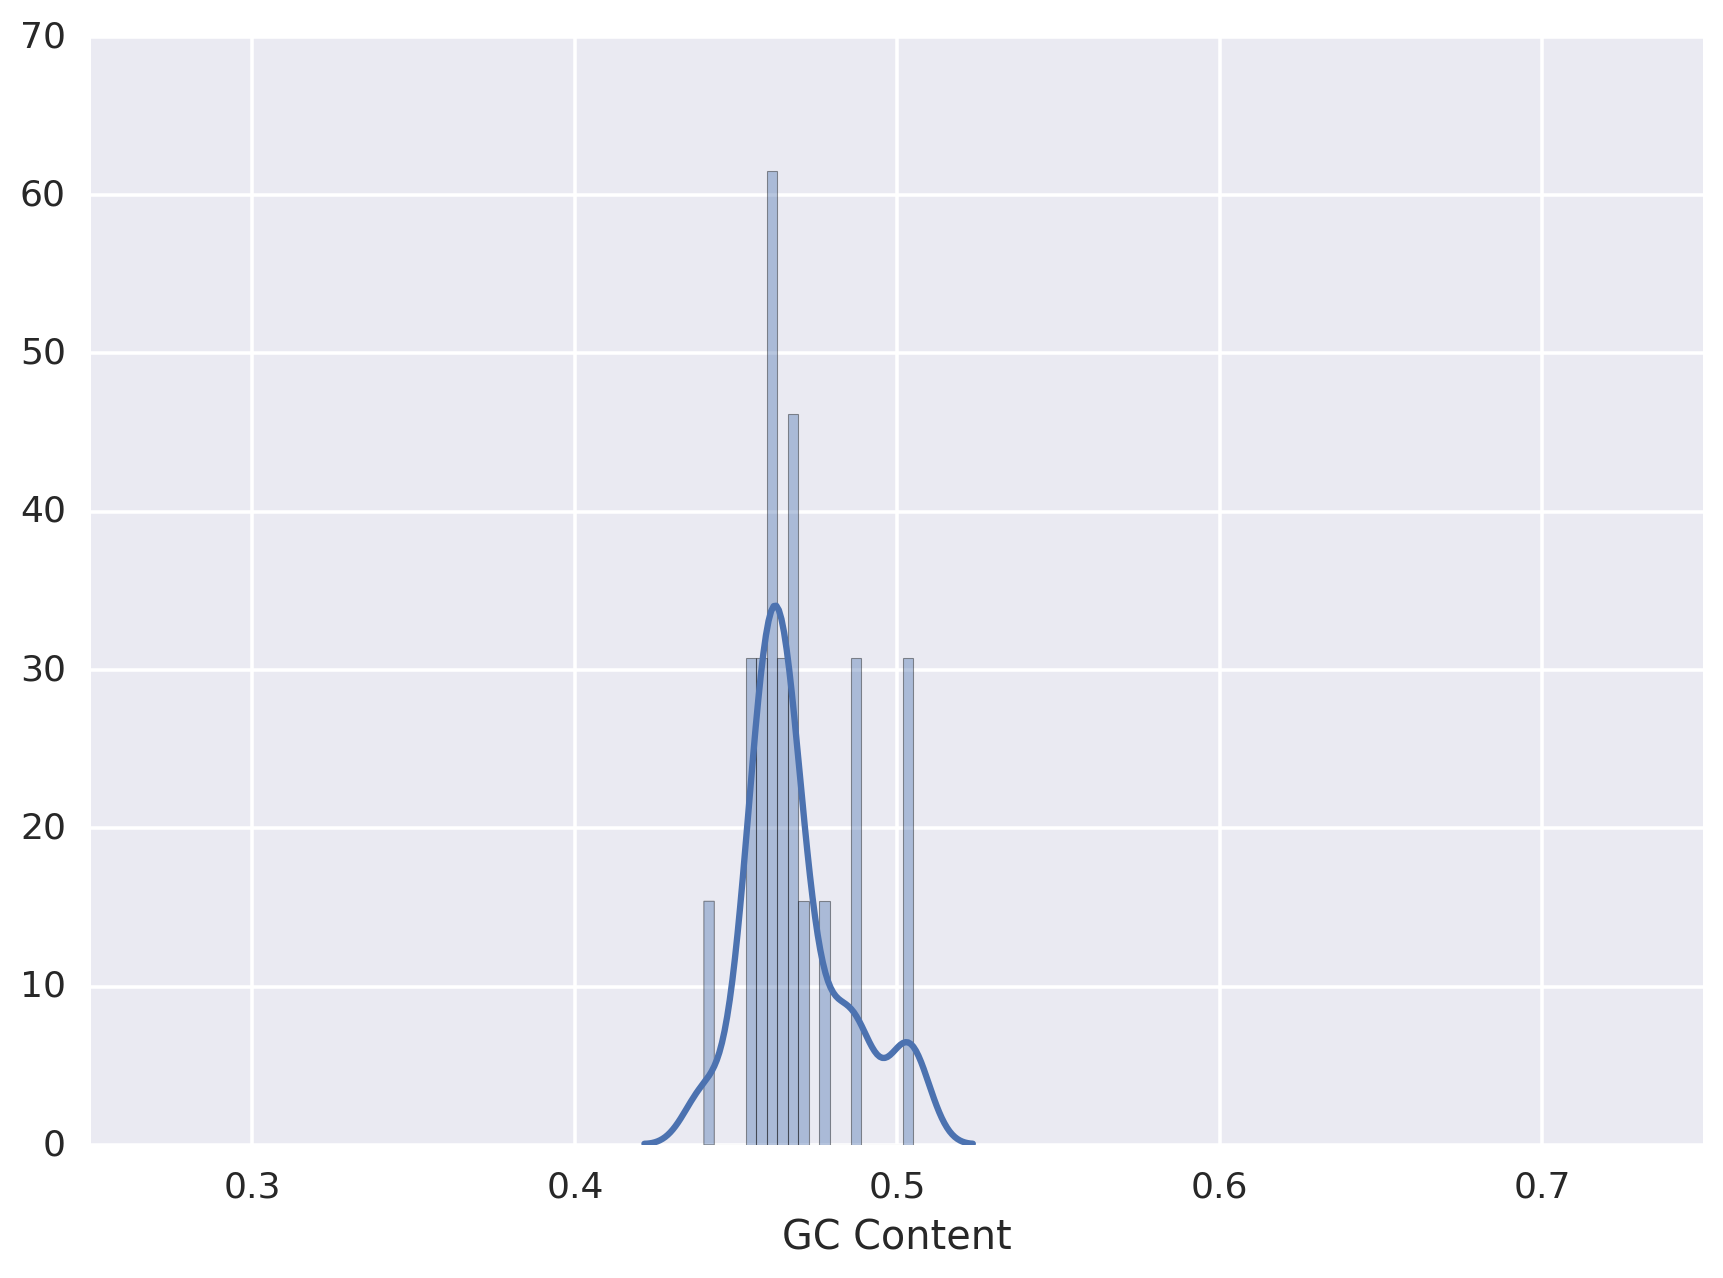

In [5]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()

sns.distplot(summary_frame['averageTagsPerPosition'], bins=20)
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame['averageFragmentGCcontent'], bins=20)
plt.xlabel('GC Content')
plt.xlim([0.25,0.75])
plt.show()



### Filter Samples According to Mapping Quality

In [6]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 5000000
pbcThreshold=0.0
gcThreshold=0.10
clonalityThreshold = 4
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

filtered_summary_frame = filtered_summary_frame[np.abs(filtered_summary_frame['averageFragmentGCcontent'] - 0.5) <=gcThreshold]

filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['averageTagsPerPosition'] <= clonalityThreshold]


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

filtered_summary_frame.to_csv('filtered_qc_metrics.tsv', sep='\t', index=False)

Number of Samples: 20
Number of discarded samples: 0
Number of Samples remaining after filtering: 20


### Filter away samples that have advanced PD

In [7]:
advanced_patients = ['PD-13', 'PD-16', 'PD-19', 'Control-26', 'Control-37']
filtered_summary_frame = filtered_summary_frame[~filtered_summary_frame['treatment'].isin(advanced_patients)]
print(filtered_summary_frame.shape)

(20, 18)


### Filter Away patients with long disease duration

In [8]:
long_disease_duration_patients = clinical_frame[clinical_frame['Disease duration'] > 4]['RNA-seq']
filtered_summary_frame = filtered_summary_frame[~filtered_summary_frame['sampleName'].isin(long_disease_duration_patients)]
print(filtered_summary_frame.shape)

(20, 18)


## Calculate Tag Counts and RPKM

In [43]:
# %%capture
filteredTagDirectories = ' '.join([tagDirPath +x for x in filtered_summary_frame['sampleName']])
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >./rpkm.tsv
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -noadj -d $filteredTagDirectories >./raw.tsv

	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-32_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-44_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-20_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-48_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-30_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-27_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-22_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-34_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-17_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/ana

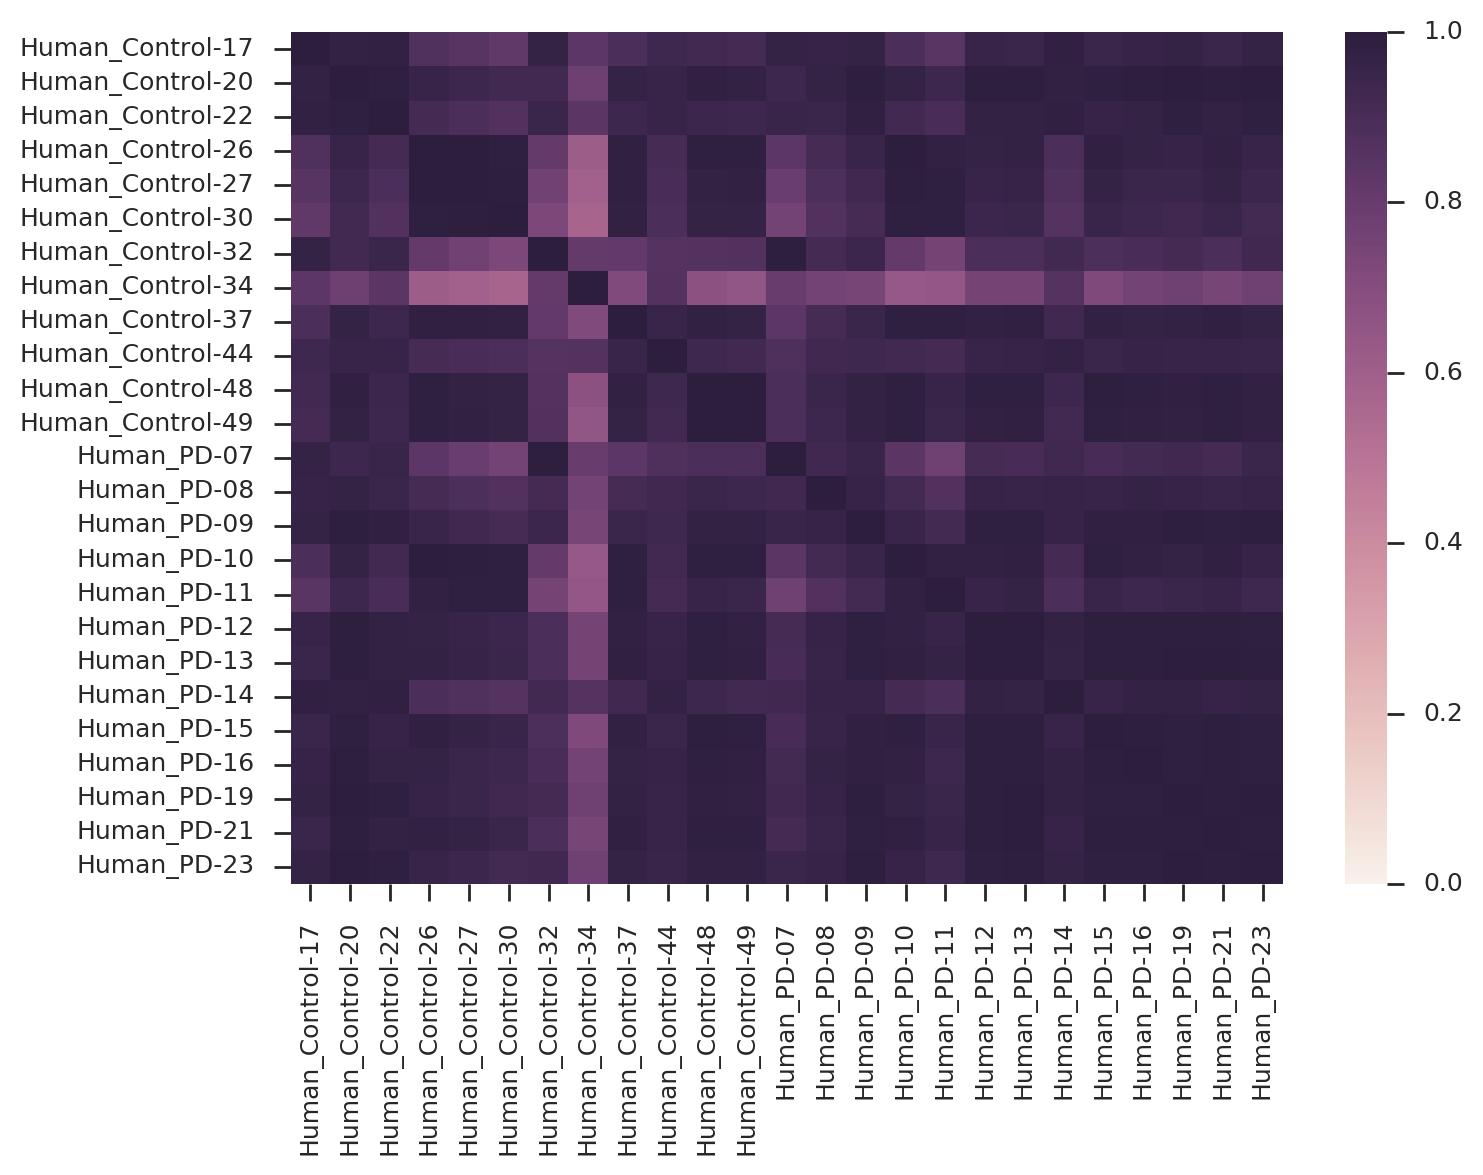

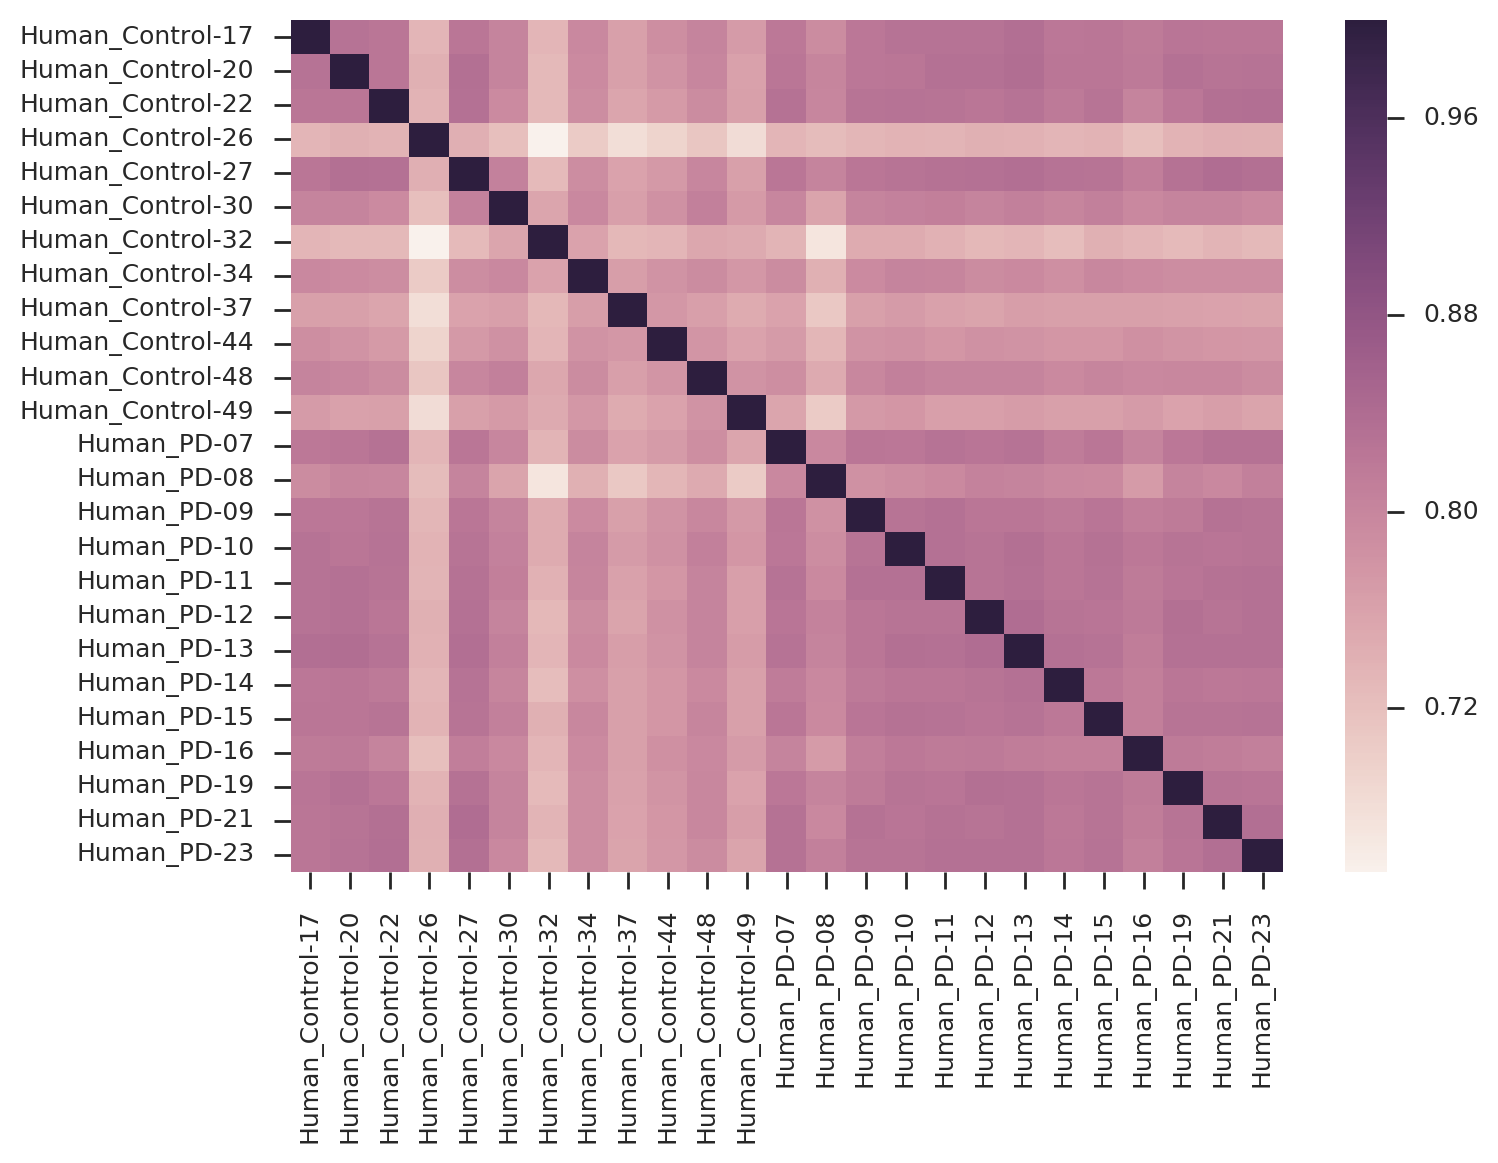

In [70]:
all_rpkm_frame = pd.read_csv("rpkm_all.tsv",sep="\t")
columns = all_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
all_rpkm_frame.columns = columns    
all_rpkm_frame['gene'] = [x.split("|")[0] for x in all_rpkm_frame['Annotation/Divergence']]
columns = list(all_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
all_rpkm_frame = all_rpkm_frame[columns]


### cluster samples according to correlation
samples = all_rpkm_frame.columns.values[9:]

labels = ['_'.join(x.split('_')[0:3]).replace('RNA_','') for x in columns[9:]]

spearman_matrix = np.zeros((len(samples), len(samples)))
pearson_matrix = np.zeros((len(samples), len(samples)))
for i in range(len(samples)):
    spearman_matrix[i][i]=1.0
    pearson_matrix[i][i]=1.0

for i in range(len(samples) - 1):
    for j in range(i+1, len(samples)):
        values_1 = all_rpkm_frame[samples[i]].values
        values_2 = all_rpkm_frame[samples[j]].values
        pearson, pearson_pval = stats.pearsonr(values_1,values_2)
        spearman, spearman_pval = stats.spearmanr(values_1,values_2)
        pearson_matrix[i][j] = pearson
        pearson_matrix[j][i] = pearson
        
        spearman_matrix[i][j] = spearman
        spearman_matrix[j][i] = spearman
        
        

sns.set_context('notebook', font_scale=0.9)
cg = sns.heatmap(pearson_matrix, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

cg = sns.heatmap(spearman_matrix, xticklabels=labels, yticklabels=labels)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

sns.set_context('notebook', font_scale=1.0)

In [43]:
if not os.path.isdir('scatter_plots'):
    os.mkdir('scatter_plots')
treatments = sorted(list(set(summary_frame.index)))
for i in range(len(treatments)):
    for j in range(i, len(treatments)):
        print(treatments[i], treatments[j])
        columns = sorted(list(set(list(summary_frame.loc[treatments[i],'sampleName']) + 
                              list(summary_frame.loc[treatments[j],'sampleName']))))
        data = np.log2(all_rpkm_frame.loc[:,columns] + 1)
        data = data[data.sum(axis=1) > 0.0]
        data.columns = ['_'.join(x.split('_')[0:3]).replace('Human-HMDM-','').replace('RNA_','') for x in columns]
        print(data.columns)
        cg = sns.pairplot(data, 
                          x_vars=[x for x in data.columns.values if treatments[i][1] in x],
                          y_vars=[x for x in data.columns.values if treatments[j][1] in x]
                         )
        
        plt.savefig('./scatter_plots/' + '_'.join(treatments[i] + treatments[j]) + '_logRpkm.png')
        plt.close()

('Human', 'Control') ('Human', 'Control')
Index(['Human_Control-17', 'Human_Control-20', 'Human_Control-22',
       'Human_Control-26', 'Human_Control-27', 'Human_Control-30',
       'Human_Control-32', 'Human_Control-34', 'Human_Control-37',
       'Human_Control-44', 'Human_Control-48', 'Human_Control-49'],
      dtype='object')
('Human', 'Control') ('Human', 'PD')
Index(['Human_Control-17', 'Human_Control-20', 'Human_Control-22',
       'Human_Control-26', 'Human_Control-27', 'Human_Control-30',
       'Human_Control-32', 'Human_Control-34', 'Human_Control-37',
       'Human_Control-44', 'Human_Control-48', 'Human_Control-49',
       'Human_PD-07', 'Human_PD-08', 'Human_PD-09', 'Human_PD-10',
       'Human_PD-11', 'Human_PD-12', 'Human_PD-13', 'Human_PD-14',
       'Human_PD-15', 'Human_PD-16', 'Human_PD-19', 'Human_PD-21',
       'Human_PD-23'],
      dtype='object')
('Human', 'PD') ('Human', 'PD')
Index(['Human_PD-07', 'Human_PD-08', 'Human_PD-09', 'Human_PD-10',
       'Human_PD-

In [71]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))


# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['sampleName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
columns = [x.split('_')[2] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.gene.values
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.max(axis=1) >= 10]

to_write_frame = filtered_rpkm_frame.copy()
to_write_frame = to_write_frame[to_write_frame.max(axis=1) >= 10]
# to_write_frame.index = [refseq_gene_mapping[x] for x in to_write_frame.index.values]
to_write_frame.to_csv('filtered_rpkm.tsv', sep='\t')

# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_median_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for gene in pivoting_frame.columns:
    refseq = gene_refseq_mapping[gene.upper()]
    gene_rpkms = pivoting_frame[gene].values
    rpkm_med = np.median(gene_rpkms)
    for rpkm in gene_rpkms:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene)
        _median_rpkm.append(rpkm_med)
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'median rpkm':_median_rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)



## Variance Analysis

In [72]:
pd_cols = [x for x in filtered_rpkm_frame.columns if 'PD' in x]

control_cols = [x for x in filtered_rpkm_frame.columns if not 'PD' in x]

In [73]:
def calc_mad(vals):
    med = np.median(vals)
    abs_devs = [abs(x - med) for x in vals]
    mad = np.median(abs_devs)
    return mad

In [74]:
pd_mads = filtered_rpkm_frame[pd_cols].apply(calc_mad,axis=1)

control_mads = filtered_rpkm_frame[control_cols].apply(calc_mad,axis=1)

pd_vars = filtered_rpkm_frame[pd_cols].var(axis=1)

control_vars = filtered_rpkm_frame[control_cols].var(axis=1)




NME3
LOC728392
AKNA
GIMAP1-GIMAP5
SNORD116-18


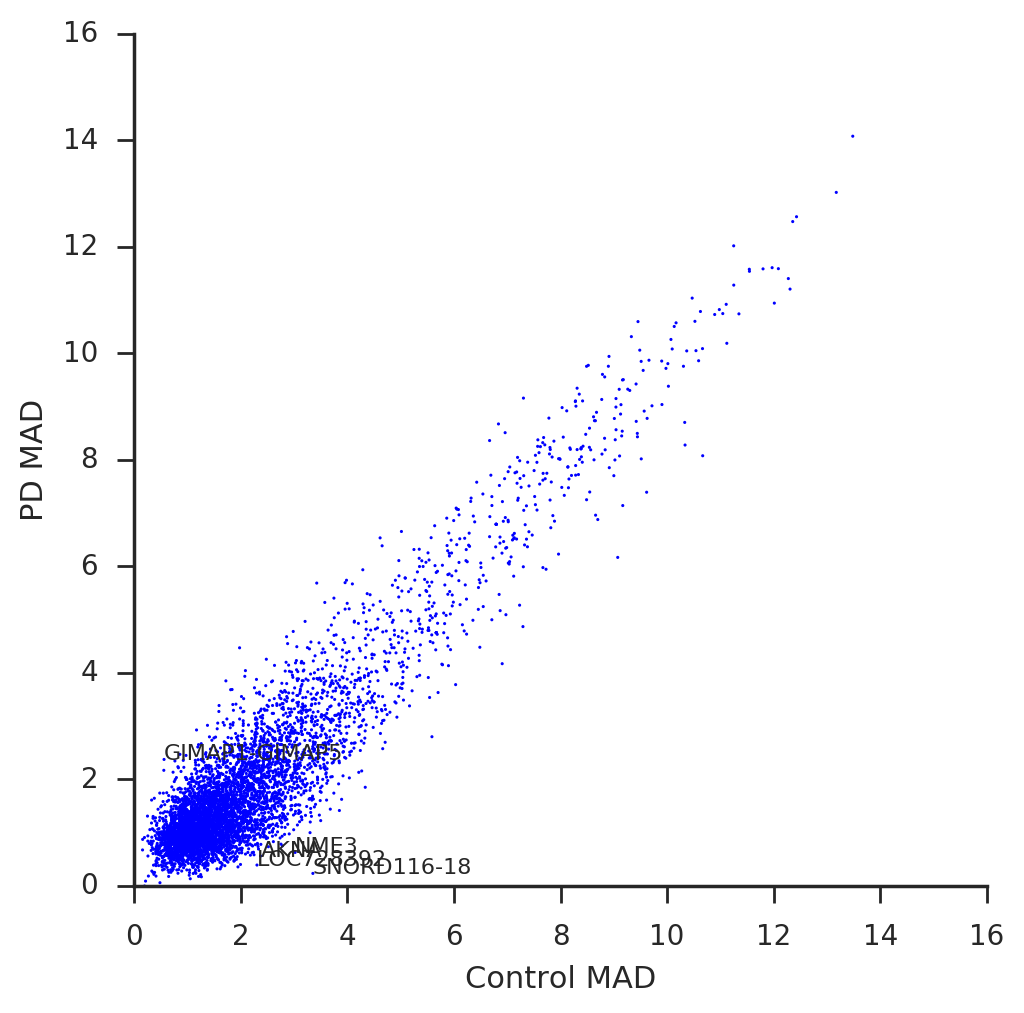

In [75]:
sns.set_style('ticks')
control_mads_log = np.log2(control_mads+1)
pd_mads_log = np.log2(pd_mads + 1)

plt.scatter(control_mads_log, 
            pd_mads_log, 
            marker = '.', edgecolors='None', s=5)
plt.xlabel('Control MAD')
plt.ylabel('PD MAD')

gene_names = filtered_rpkm_frame.index.values
tuples = zip(control_mads_log, pd_mads_log, gene_names)

for x, y, label in tuples:
    fold = x/y
    if (fold >= 4 or fold <=1/4) and (x>=2 or y>=2) :
        plt.annotate(label, size=8, xy=(x,y))
        print(label)
plt.xlim(0,16)
plt.ylim(0,16)
ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
sns.despine()

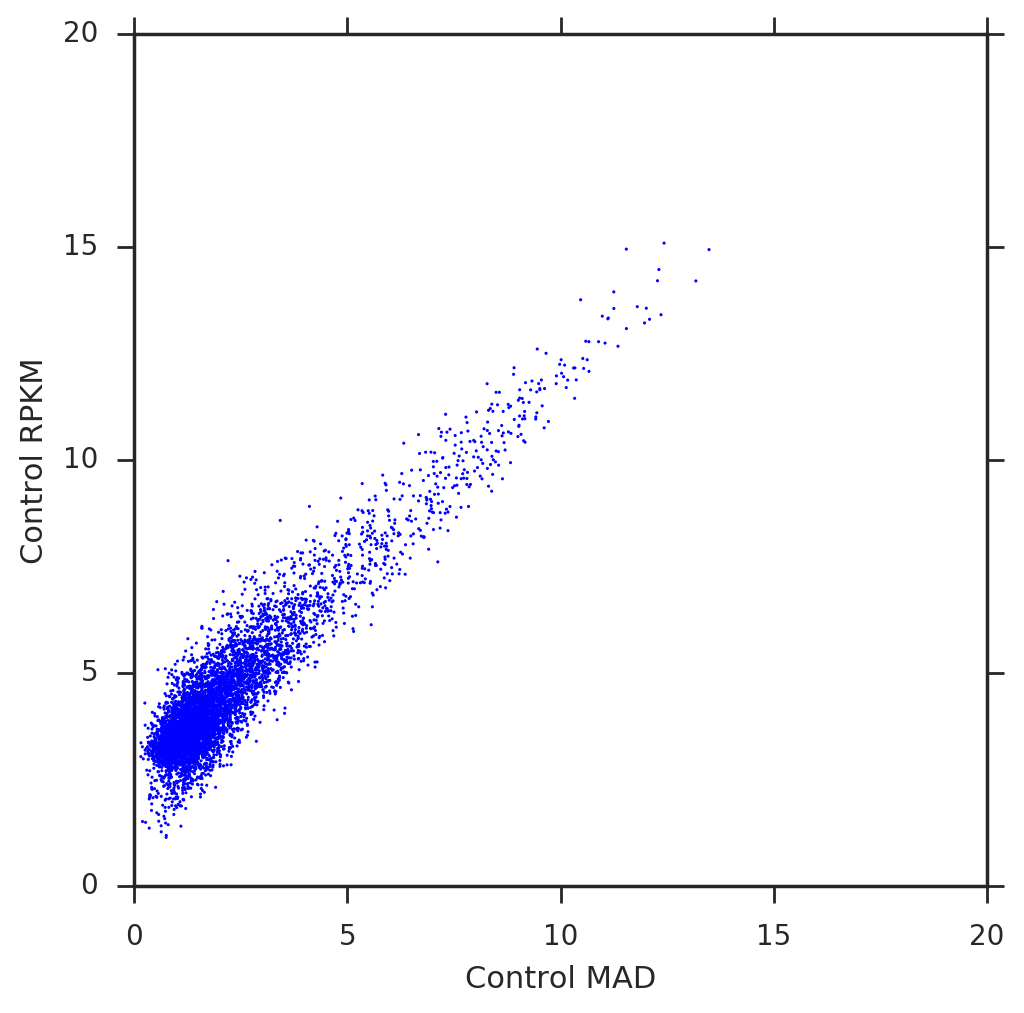

In [76]:
rpkms = filtered_rpkm_frame[control_cols].mean(axis=1)
plt.scatter(np.log2(control_mads+1), 
            np.log2(rpkms+1), marker = '.', edgecolors='None', s=5)
plt.xlabel('Control MAD')
plt.ylabel('Control RPKM')
plt.xlim([0,20])
plt.ylim([0,20])

ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

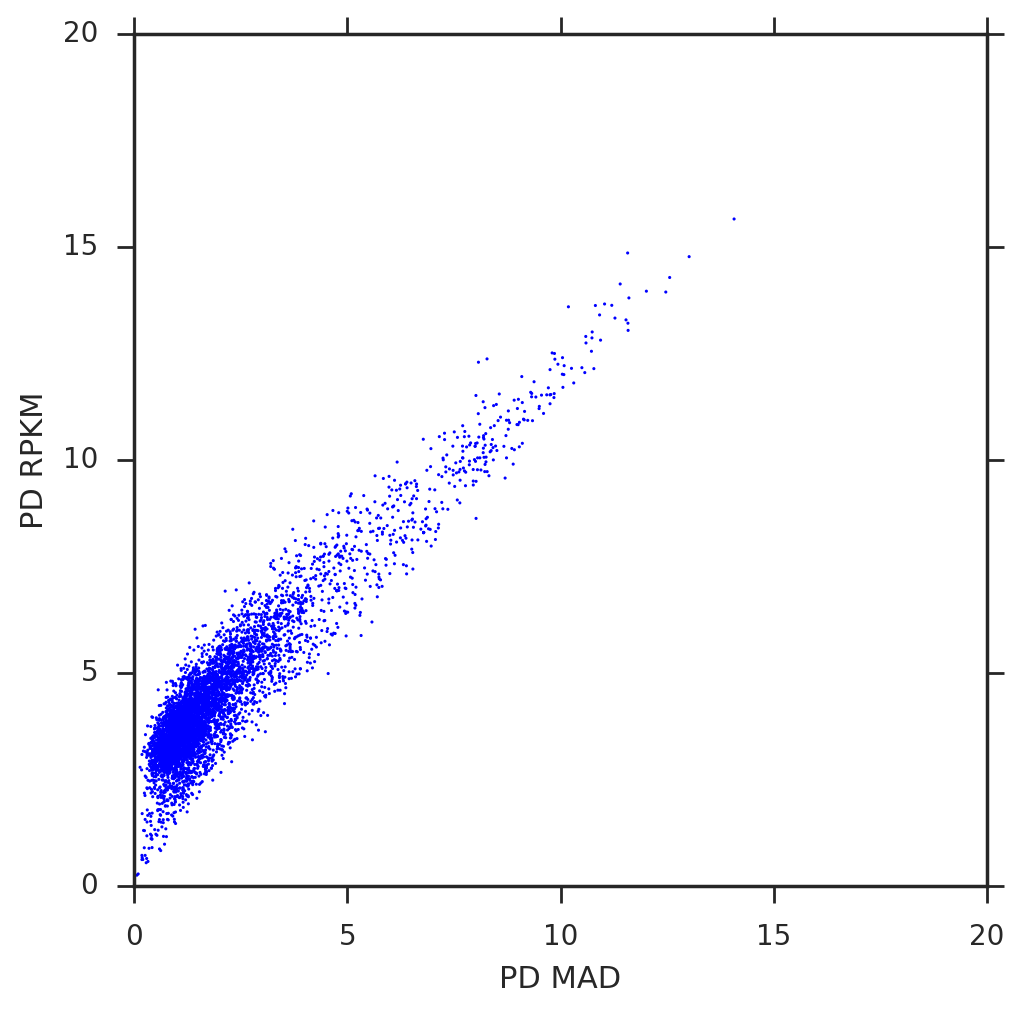

In [77]:
rpkms = filtered_rpkm_frame[pd_cols].mean(axis=1)
plt.scatter(np.log2(pd_mads+1), 
            np.log2(rpkms+1), marker = '.', edgecolors='None', s=5)
plt.xlabel('PD MAD')
plt.ylabel('PD RPKM')
plt.xlim([0,20])
plt.ylim([0,20])


ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

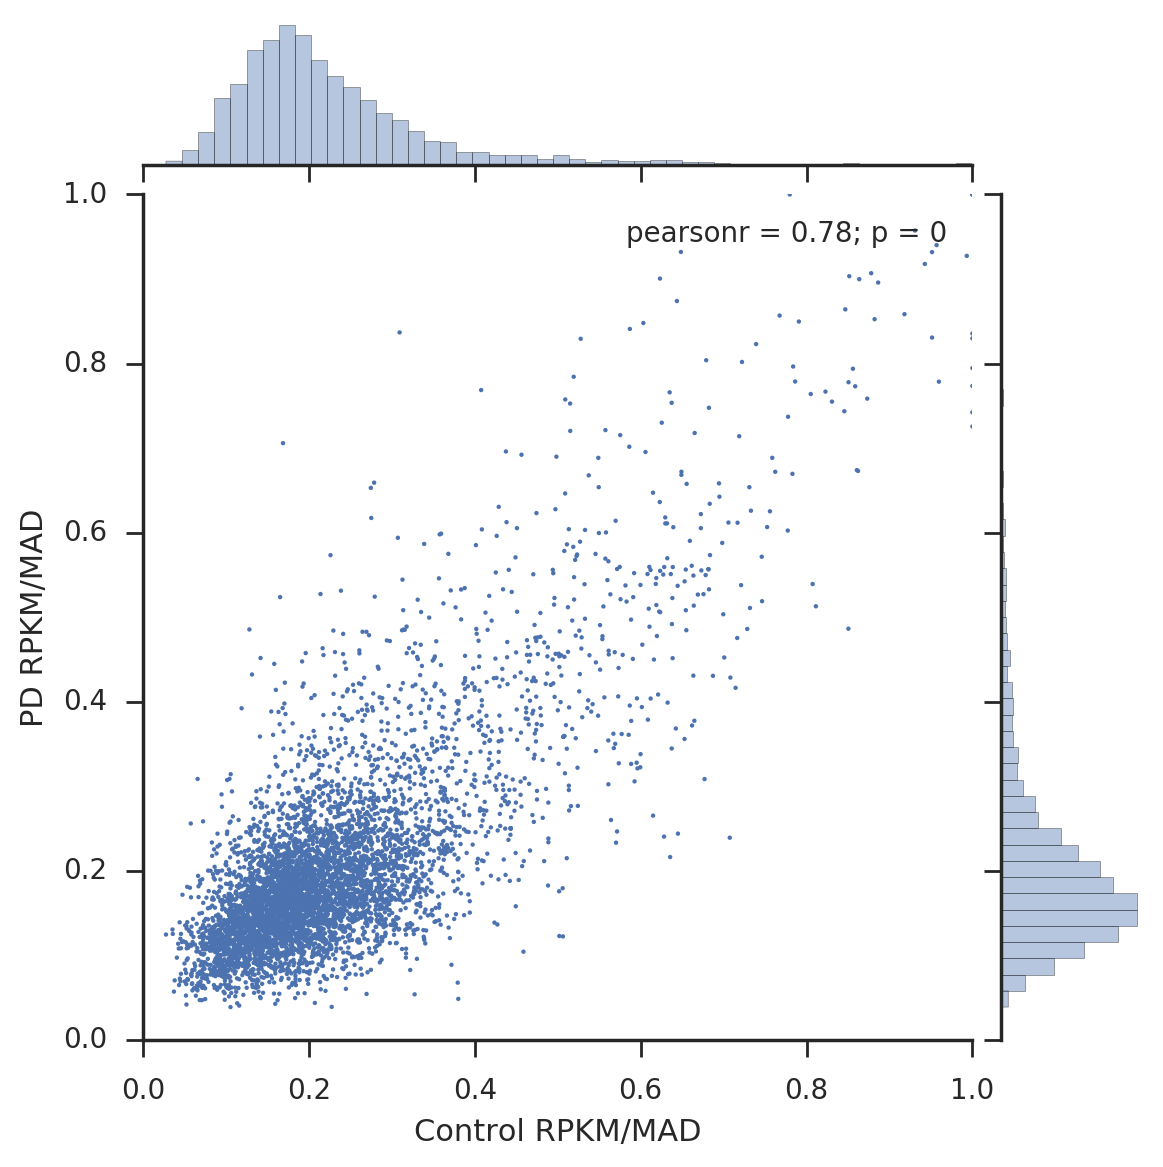

In [78]:
pd_rpkms = filtered_rpkm_frame[pd_cols].median(axis=1)
control_rpkms = filtered_rpkm_frame[control_cols].median(axis=1)
pd_ratios = (pd_mads +1) / (pd_rpkms+1)
control_ratios = (control_mads +1) / (control_rpkms+1)

jg = sns.jointplot(control_ratios,
            pd_ratios, 
            xlim=(0,1),
            ylim=(0,1),
            marker = '.', edgecolors='None', s=10)

jg.ax_joint.set_xlabel('Control RPKM/MAD')

jg.ax_joint.set_ylabel('PD RPKM/MAD')


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


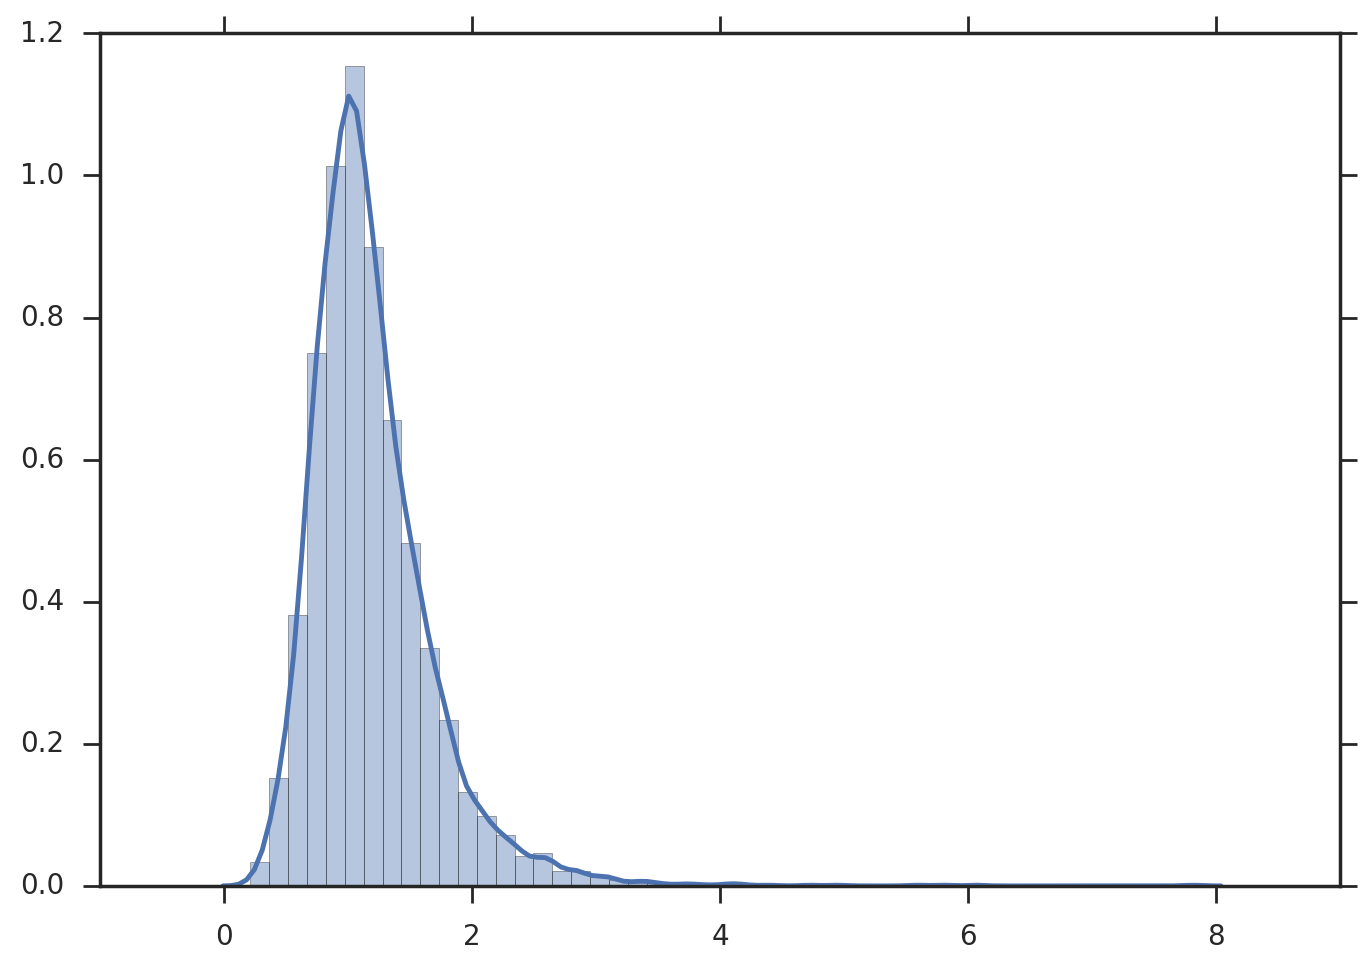

In [79]:
ratio_ratios = control_ratios/pd_ratios
sns.distplot(ratio_ratios)

In [80]:
zscores = pd.Series(data = scipy.stats.zscore(ratio_ratios),
                    index = ratio_ratios.index.values)

## Run IDR

In [224]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame['sampleName'], filtered_summary_frame['simpleTreatment']))
conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
! echo python /gpfs/data01/glasslab/home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

python /gpfs/data01/glasslab/home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv /gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//idr/ Control Control Control Control Control Control Control Control Control Control PD PD PD PD PD PD PD PD PD PD


In [81]:
idr_rpkm_frame = pd.read_csv('idr/idr_union.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
#         columns[i] = originalName_simpleName_dict[columns[i].split("/")[-1].split()[0]]
        columns[i] =columns[i].split("/")[-1].split()[0].split('_')[2]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = [x.upper() for x in idr_rpkm_frame['gene'].values]
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = col.split('-')[0]
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame.index = idr_rpkm_frame.index.values

idr_rpkm_median_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = col.split('-')[0]
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_median_frame[treatment] = np.median(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)

idr_rpkm_median_frame.index = idr_rpkm_frame.index.values

## Calcuate Differential Expression with EdgeR

In [19]:
run_genes_dict = {} # {excludedSamples:{significantGenes}}

In [50]:
# %%capture
raw_frame = pd.read_csv('./raw.tsv', sep='\t')
# columns = raw_frame.columns.values
# columns[0] = "refseq"
# for i in range(len(columns)):
#     if "total" in columns[i]:
#         columns[i] = ' '.join(columns[i].split("/")[-1].split()[0:3])
# raw_frame.columns = columns    

# raw_frame.columns


In [34]:
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['sampleName'], filtered_summary_frame['simpleTreatment']))
samples = [x.split('/')[-1].split()[0] for x in raw_frame.columns[8:].values]

conditions = " ".join([sample_condition_dict[x] for x in samples])
!getDiffExpression.pl raw.tsv $conditions > homer_diffExpresion.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-regulated in PD vs. Control: 2 (0.008%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PD vs. Control: 35 (0.132%) [log2fold<-1, FDR<0.05]



In [82]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [83]:
run_genes_dict['All Patients'] = set(diffExpression_frame[diffExpression_frame['Control vs. PD adj. p-value'] <0.05]['gene'].values)



In [59]:
samples = sorted(set(raw_frame.columns.values[8:]))

labels = treatments
run_excluded_dict = {} #{run:[excludedSamples]}

skf = cross_validation.StratifiedKFold(labels, 5, shuffle=True)
runNumber = 0
numExcluded = 4
for test_indices, exclude_indices in skf:
    runNumber += 1

    # get samples to use
    test_samples = [samples[i] for i in test_indices]
    excluded_samples = [samples[i] for i in exclude_indices]
    run_excluded_dict[runNumber] = excluded_samples
    # create raw.tsv for current cross-validation set
    current_raw_frame = raw_frame[list(raw_frame.columns.values[:8]) + test_samples]
    columns = current_raw_frame.columns.values
#     columns[0] = 'Transcript/RepeatID (cmd=' + ' '.join(test_samples) + ')'
    current_raw_frame.columns = columns
    current_raw_path = 'raw_' + str(runNumber) + '.tsv'
    current_raw_frame.to_csv(current_raw_path, index=False, sep='\t')
    conditions = " ".join([x.split('/')[-1].split('_')[2].split('-')[0] for x in test_samples])
    
#     # call EdgeR
    current_diffExpression_path = 'homer_diffExpression_' + str(runNumber) + '.tsv'
    ! getDiffExpression.pl $current_raw_path $conditions > $current_diffExpression_path
    


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-regulated in PD vs. Control: 0 (0.000%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PD vs. Control: 12 (0.045%) [log2fold<-1, FDR<0.05]


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-regulated in PD vs. Control: 0 (0.000%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PD vs. Control: 9 (0.034%) [log2fold<-1, FDR<0.05]


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-r

In [84]:
significant_genes_intersection = None
significant_genes_union = set()

for i in range(1,6):
    # read current differentially expressed gene output
    current_path = 'homer_diffExpression_' + str(i) + '.tsv'
    current_diffExpression_frame = pd.read_csv(current_path, sep='\t')
    columns = current_diffExpression_frame.columns.values
    columns[0]='refseq'
    columns = [x.split('/')[-1] if '/' in x else x for x in columns]
    current_diffExpression_frame.columns=columns
    current_diffExpression_frame.index = current_diffExpression_frame.refseq.values
    current_diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in current_diffExpression_frame['Divergence']]
    columns = ['refseq', 'gene'] + [x for x in current_diffExpression_frame.columns if 'vs.' in x]
    current_diffExpression_frame = current_diffExpression_frame[columns]
    
    significant_genes = set(current_diffExpression_frame[current_diffExpression_frame['Control vs. PD adj. p-value'] <0.05]['gene'].values)

    print(len(significant_genes))    
    run_genes_dict[str(i)]  = significant_genes
    if significant_genes_intersection == None:

        significant_genes_intersection  = significant_genes
    else:
        significant_genes_intersection = significant_genes_intersection.intersection(significant_genes)
    significant_genes_union = significant_genes_union.union(significant_genes)

13
13
39
26
75


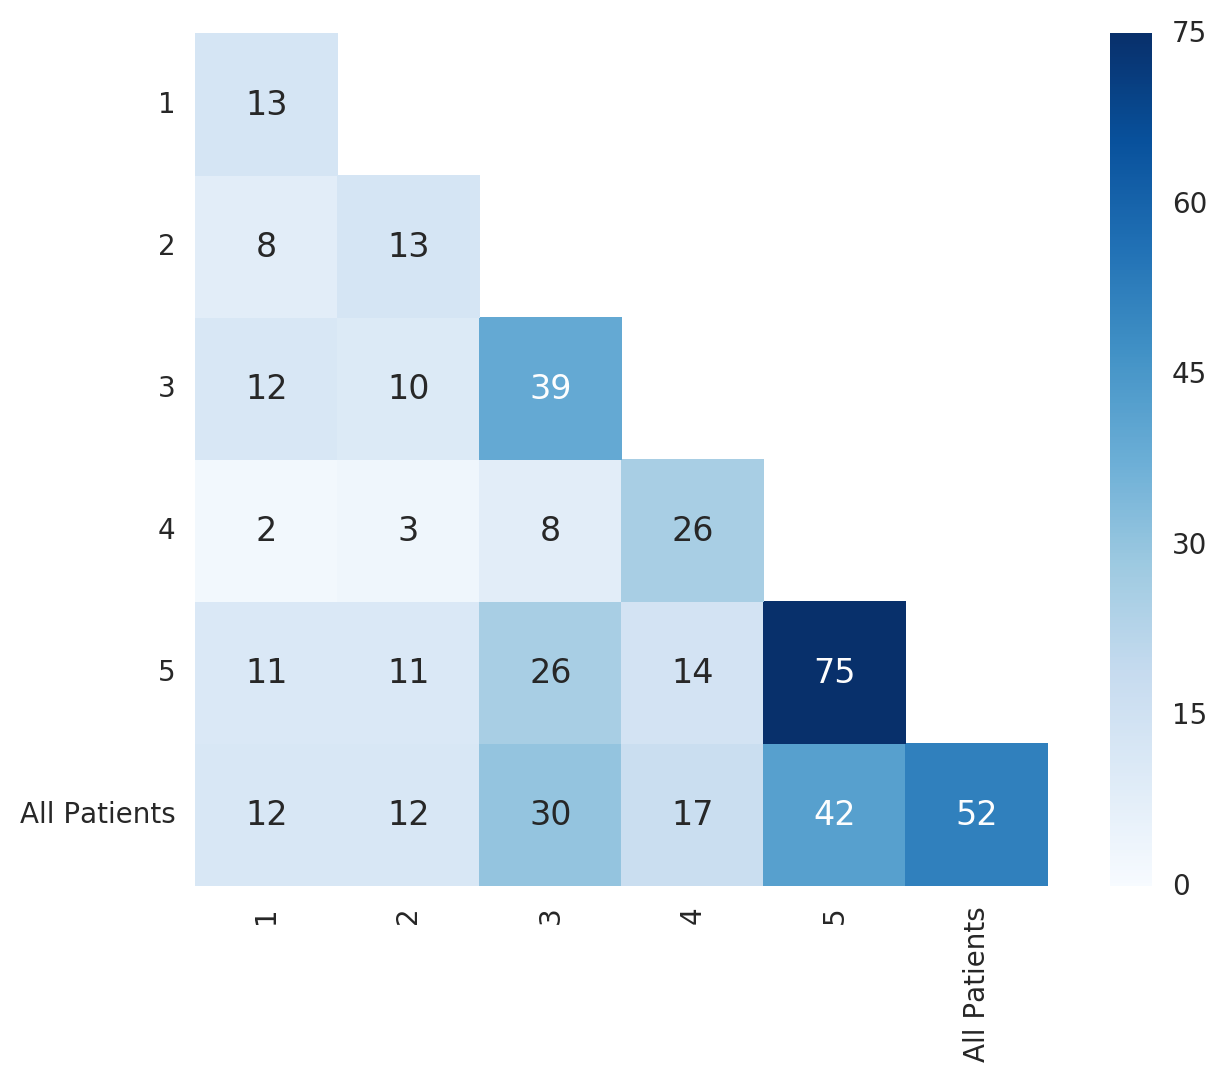

In [85]:
sorted_keys = sorted(run_genes_dict.keys())
matrix = np.zeros((6,6))
for i in range(matrix.shape[0] - 1):
    key_1 = sorted_keys[i]
    genes_1 = run_genes_dict[key_1]
    matrix[i][i] = len(genes_1)
    for j in range(i + 1, matrix.shape[0]):
        key_2 = sorted_keys[j]
        genes_2 = run_genes_dict[key_2]
        intersection = genes_1.intersection(genes_2)
        matrix[j][i] = len(intersection)
matrix[5][5] = len(run_genes_dict['All Patients'])
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
for i in range(6):
    mask[i][i]=False
with sns.axes_style("white"):
    sns.heatmap(matrix, 
                mask=mask,
                xticklabels= sorted_keys,
                yticklabels = sorted_keys,
                cmap='Blues',
                fmt='g',
                annot=True,
                square=True)
    plt.yticks(rotation=0)  
    plt.xticks(rotation=90)  
    plt.savefig('./figures/cross_validation_overlap.pdf',bbox_inches='tight')

## Statistical Testing

### Test Difference in Variation and Difference in Medians

In [116]:
variability_pvals = []
median_pvals = []
genes = []
control_medians = []
pd_medians = []
for refseq in set(filtered_rpkm_plottingFrame['refseq'].values):

    gene = refseq_gene_mapping[refseq]
    currentVals = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['refseq'] == refseq]
    
    control_rpkms = currentVals[currentVals['treatment'] == 'Control']['rpkm'].values
    pd_rpkms = currentVals[currentVals['treatment'] == 'PD']['rpkm'].values

    control_med = np.median(control_rpkms)
    pd_med = np.median(pd_rpkms)

    control_medians.append(control_med)
    pd_medians.append(pd_med)
    
    control_distances = [abs(x - control_med) for x in control_rpkms]
    pd_distances = [abs(x - pd_med) for x in pd_rpkms]

    ks_stat, p_ks_variability = stats.ks_2samp(control_distances, pd_distances)
    ks_stat, p_ks_median = stats.ks_2samp(control_rpkms, pd_rpkms)
    
    variability_pvals.append(p_ks_variability)
    median_pvals.append(p_ks_median)
    

    genes.append(gene)
gene_edgerp_dict = dict(zip(diffExpression_frame['gene'], diffExpression_frame['Control vs. PD adj. p-value'].values))
edger_pvals = [gene_edgerp_dict[x] if x in gene_edgerp_dict else 1.0 for x in genes]

pval_frame = pd.DataFrame({'Gene':genes, 
                           'variability p-value':variability_pvals,
                           'median p-value':median_pvals,
                           'Control Median':control_medians,
                           'PD Median':pd_medians, 
                           'EdgeR p-value':edger_pvals
                          })
            

#### Disregulated Genes

In [87]:
disregulated_genes = pval_frame[(pval_frame['median p-value'] > 0.005) & 
                                (pval_frame['variability p-value'] < 0.001) &
                                (pval_frame['Gene'].isin(filtered_rpkm_frame[filtered_rpkm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
print(len(disregulated_genes))

30


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(0, 10)

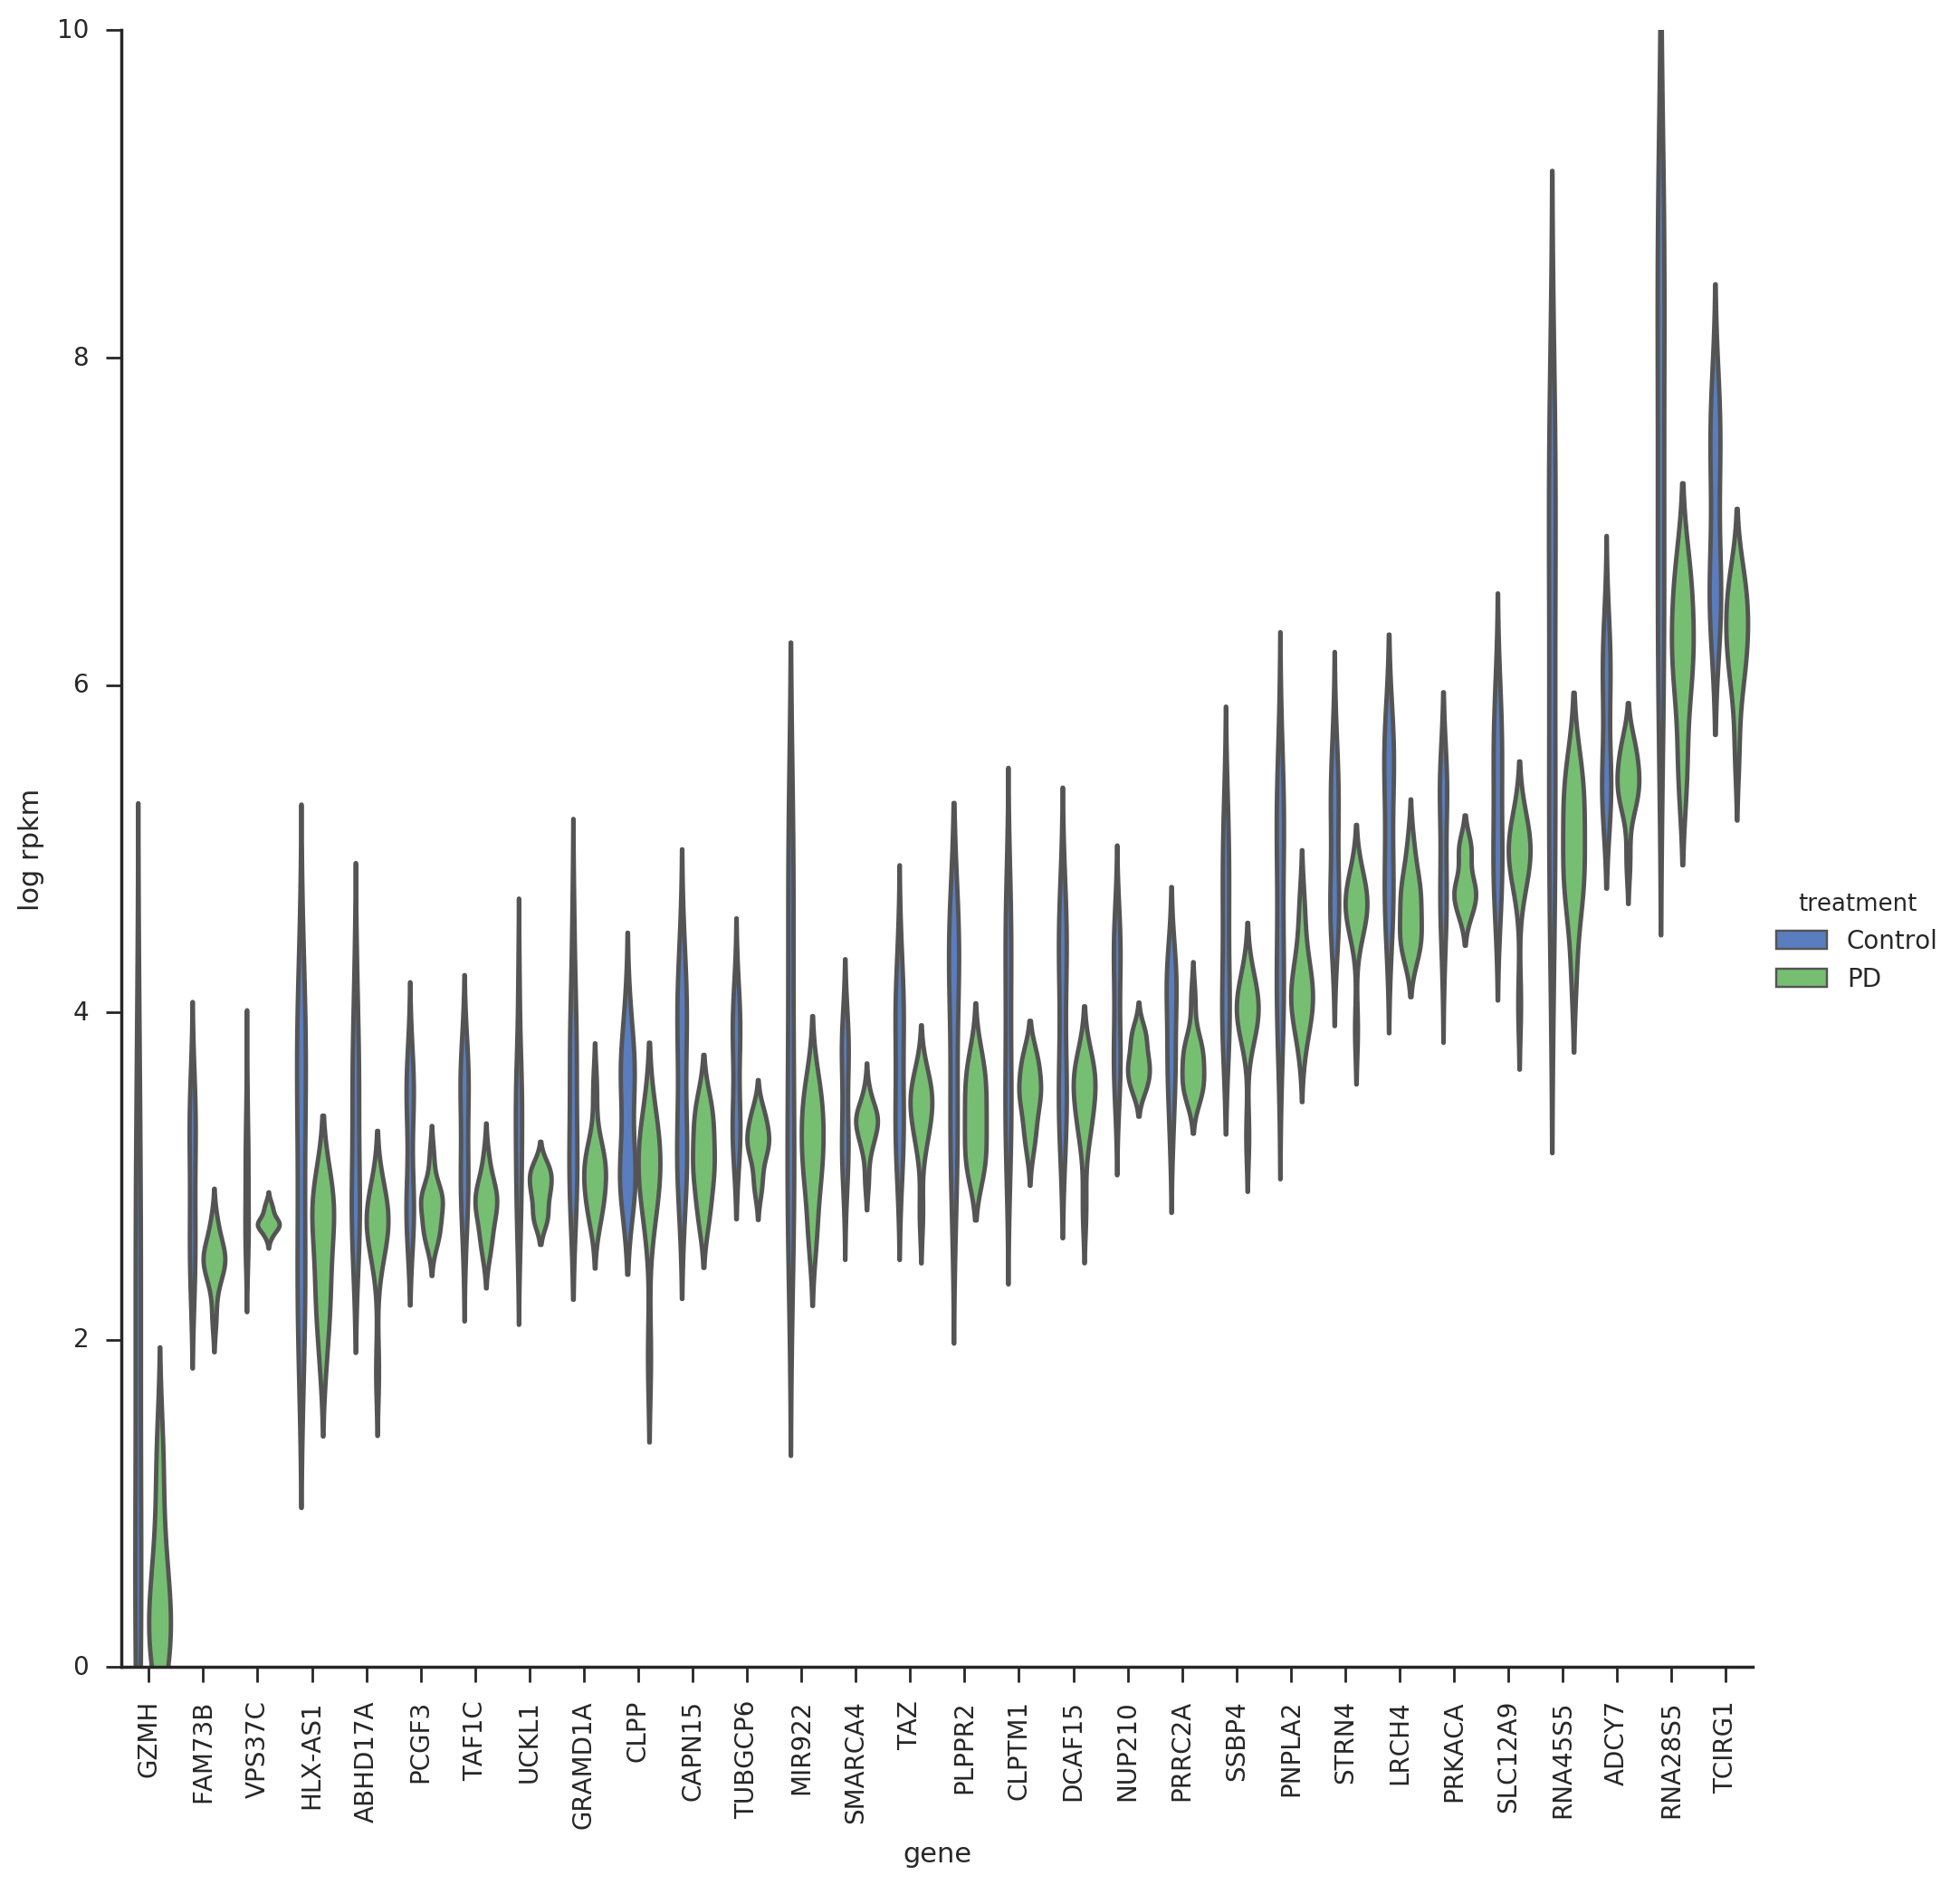

In [88]:
data = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['gene'].isin(disregulated_genes)]
data.sort('median rpkm', inplace=True)
data['log rpkm'] = np.log2(data['rpkm'] + 1)
sns.factorplot(data = data, 
               x='gene', 
               y = 'log rpkm', 
               hue='treatment', 
               kind='violin', 
               inner = None,
               size=10,
              palette='muted')
plt.xticks(rotation=90)

plt.ylim(0,10)

#### Differentially Expressed

In [89]:
diff_expressed_genes = pval_frame[(pval_frame['median p-value'] < 0.005) & 
                                (pval_frame['variability p-value'] > 0.001) &
                                (pval_frame['Gene'].isin(filtered_rpkm_frame[filtered_rpkm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
print(len(diff_expressed_genes))

28


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text xticklabel objects>)

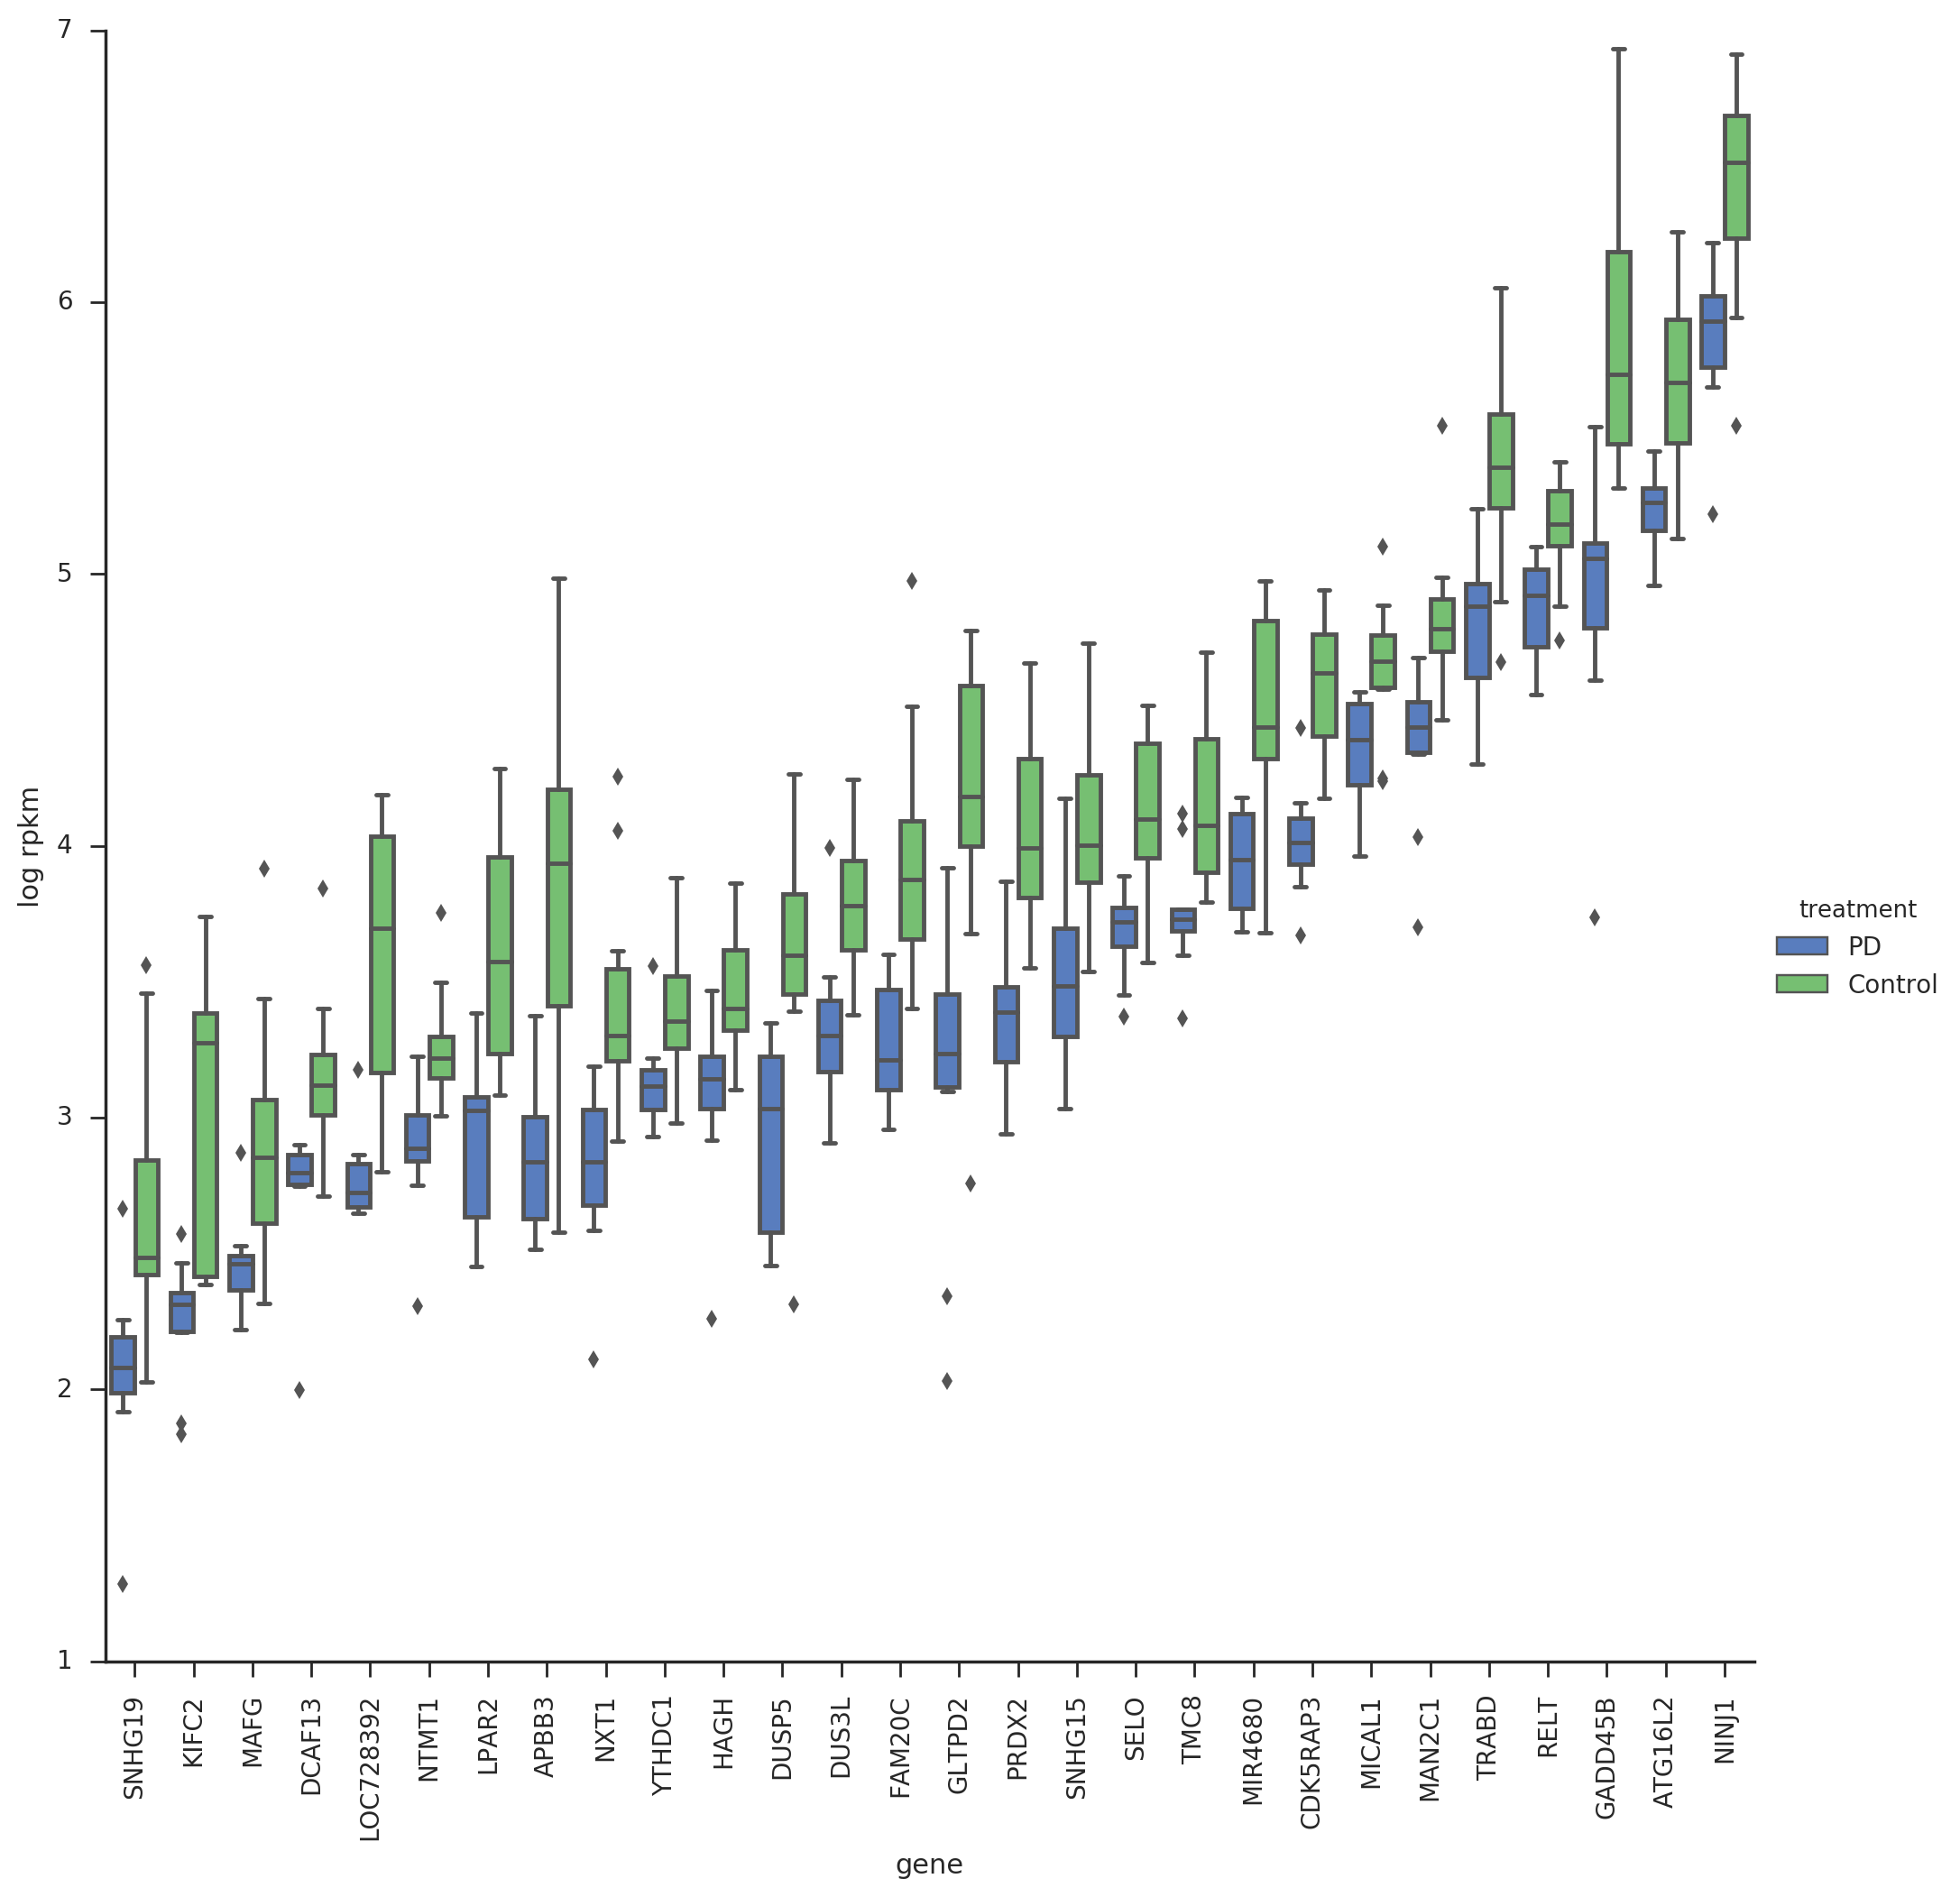

In [90]:
data = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['gene'].isin(diff_expressed_genes)]
data['log rpkm'] = np.log2(data['rpkm'] + 1)
data.sort('median rpkm', inplace=True)
sns.factorplot(data = data, 
               x='gene', 
               y = 'log rpkm', 
               hue='treatment', 
               kind='box', 
               size=10,
               palette='muted')
plt.xticks(rotation=90)
# plt.ylim(0,50)

## Cross Validation

In [117]:
idr_genes = set(idr_rpkm_frame.index.values)
tested_genes = pval_frame['Gene'].values
samples = sorted(set(filtered_rpkm_plottingFrame['simplifiedName'].values))
treatments = [x.split('-')[0] for x in samples]
labels = treatments

refseqs = []
median_pvals = []
variability_pvals = []
genes = []
up_down = []
run = []

skf = cross_validation.StratifiedKFold(labels, 5, shuffle=True)
runNumber = 0
for test_indices, exclude_indices in skf:
    runNumber += 1
    print(runNumber)
    test_samples = [samples[i] for i in test_indices]
    excluded_samples = [samples[i] for i in exclude_indices]
    current_frame = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['simplifiedName'].isin(
        test_samples)]
    print("%s %s" % (test_indices, exclude_indices))
    print("%s %s" % (test_samples, excluded_samples))
    

    for refseq in set(current_frame['refseq'].values):
        gene = refseq_gene_mapping[refseq]
        if gene in idr_genes:
            run.append(runNumber)
            currentVals = current_frame[current_frame['refseq'] == refseq]

            control_vals = currentVals[currentVals['treatment'] == 'Control']['rpkm'].values
            pd_vals = currentVals[currentVals['treatment'] == 'PD']['rpkm'].values
            
            ks_stat, p_median = stats.ks_2samp(control_vals, pd_vals)

            control_med = np.median(control_vals)
            pd_med = np.median(pd_vals)
            control_distances = [abs(x - control_med) for x in control_vals]
            pd_distances = [abs(x - pd_med) for x in pd_vals]

            ks_stat, p_variability = stats.ks_2samp(control_distances, pd_distances)
            
            variability_pvals.append(p_variability)
            median_pvals.append(p_median)
            genes.append(gene)
            refseqs.append(refseq)

            if np.mean(control_vals) < np.mean(pd_vals):
                up_down.append('up')
            else:
                up_down.append('down')
        
gene_edgerp_dict = dict(zip(diffExpression_frame['gene'], diffExpression_frame['Control vs. PD adj. p-value'].values))
edger_pvals = [gene_edgerp_dict[x] if x in gene_edgerp_dict else 1.0 for x in genes]
cv_frame = pd.DataFrame({'gene':genes,
                            'refseq':refseqs,
                            'median p-value':median_pvals,
                            'variability p-value': variability_pvals,
                            'EdgeR p-value':edger_pvals,
                            'Up or Down':up_down,
                            'Run':run
                           }) 

1
[ 0  1  2  3  4  5  8  9 10 11 13 15 16 17 18 19] [ 6  7 12 14]
['Control-17', 'Control-20', 'Control-22', 'Control-27', 'Control-30', 'Control-32', 'Control-48', 'Control-49', 'PD-07', 'PD-08', 'PD-10', 'PD-12', 'PD-14', 'PD-15', 'PD-21', 'PD-23'] ['Control-34', 'Control-44', 'PD-09', 'PD-11']
2
[ 0  1  3  5  6  7  8  9 10 12 13 14 15 17 18 19] [ 2  4 11 16]
['Control-17', 'Control-20', 'Control-27', 'Control-32', 'Control-34', 'Control-44', 'Control-48', 'Control-49', 'PD-07', 'PD-09', 'PD-10', 'PD-11', 'PD-12', 'PD-15', 'PD-21', 'PD-23'] ['Control-22', 'Control-30', 'PD-08', 'PD-14']
3
[ 0  1  2  3  4  6  7  9 10 11 12 13 14 15 16 17] [ 5  8 18 19]
['Control-17', 'Control-20', 'Control-22', 'Control-27', 'Control-30', 'Control-34', 'Control-44', 'Control-49', 'PD-07', 'PD-08', 'PD-09', 'PD-10', 'PD-11', 'PD-12', 'PD-14', 'PD-15'] ['Control-32', 'Control-48', 'PD-21', 'PD-23']
4
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 18 19] [ 0  1 15 17]
['Control-22', 'Control-27', 'Control-30

In [123]:
diff_expressed_genes = pval_frame[(pval_frame['median p-value'] < 0.005) & 
                                (pval_frame['variability p-value'] > 0.001) &
                                (pval_frame['Gene'].isin(filtered_rpkm_frame[filtered_rpkm_frame.max(axis=1) >4].index.values))
                               ]['Gene']

print(len(diff_expressed_genes))
p_threshold = 0.05
cv_genes = []


for gene in diff_expressed_genes:
    if gene in idr_genes:
        pvals = cv_frame[cv_frame['gene'] == gene]['median p-value'].values
        max_pval = np.max(pvals)
        mean_pval = np.mean(pvals)
        if max_pval < p_threshold:
#             print(gene, mean_pval, max_pval)
            cv_genes.append(gene)
print(len(cv_genes))

28
28


## Comparing EdgeR and Kruskal Wallis Test

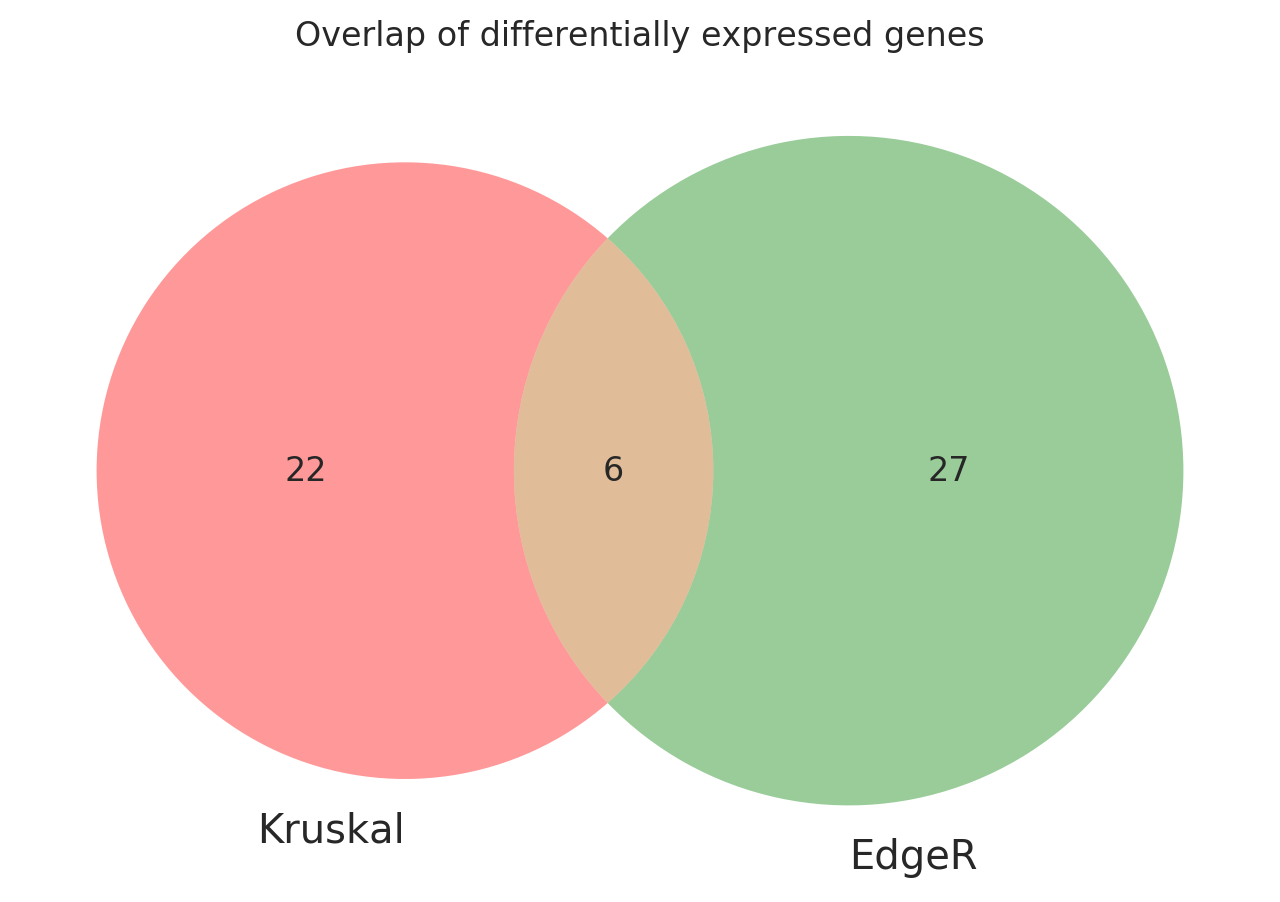

In [120]:
p_threshold = 0.05
diff_expressed_genes = pval_frame[(pval_frame['median p-value'] < 0.005) & 
                                (pval_frame['variability p-value'] > 0.001) &
                                (pval_frame['Gene'].isin(filtered_rpkm_frame[filtered_rpkm_frame.max(axis=1) >4].index.values))
                               ]['Gene']
diff_expressed_genes = set(diff_expressed_genes)
edger_genes = set(pval_frame[pval_frame['EdgeR p-value'] < p_threshold]['Gene'].values)
matplotlib_venn.venn2([kw_genes, edger_genes], set_labels = ['Kruskal', 'EdgeR'])
plt.title('Overlap of differentially expressed genes')

In [ ]:
p_threshold = 0.01
kw_genes = stat_frame[stat_frame['KW pval'] < p_threshold]['gene'].values

# kw_genes = [x for x in kw_genes if x in idr_genes]

# edger_genes = [x for x in edger_genes if x in idr_genes]

kw_genes = set(kw_genes)
matplotlib_venn.venn2([kw_genes, set(cv_genes)], set_labels = ['Kruskal (p<'+str(p_threshold)+')', 'Cross Validation (p<0.05)'])
plt.title('Overlap of differentially expressed genes')


In [ ]:
data = filtered_rpkm_frame[\
                    filtered_rpkm_frame.index.isin([gene_refseq_mapping[x] for x in cv_genes])]
# data = filtered_rpkm_frame[\
#                    filtered_rpkm_frame.index.isin([gene_refseq_mapping[x] for x in significant_genes_intersection])]
data.index = [refseq_gene_mapping[x] for x in data.index.values]
data = np.log2(data+0.01)
cg = sns.clustermap(data = data,
                    cmap='coolwarm',

                    );
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);

plt.savefig('./figures/genes_heatmap.pdf', bbox_inches='tight')

## Regressions

In [72]:
clinical_plottingFrame = filtered_rpkm_plottingFrame.copy()

clinical_plottingFrame['age'] = [simplifiedName_age_dict[x] for x in clinical_plottingFrame['simplifiedName']]
clinical_plottingFrame['duration'] = [simplifiedName_duration_dict[x] for x in clinical_plottingFrame['simplifiedName']]
clinical_plottingFrame['updrs'] = [simplifiedName_UPDRS_dict[x] for x in clinical_plottingFrame['simplifiedName']]

Age up median pearson: -0.329731207663 median spearman: -0.339042894179
Disease Duration up median pearson: 0.538896559458 median spearman: 0.62906948063
UPDRS up median pearson: 0.440013541128 median spearman: 0.645322798655


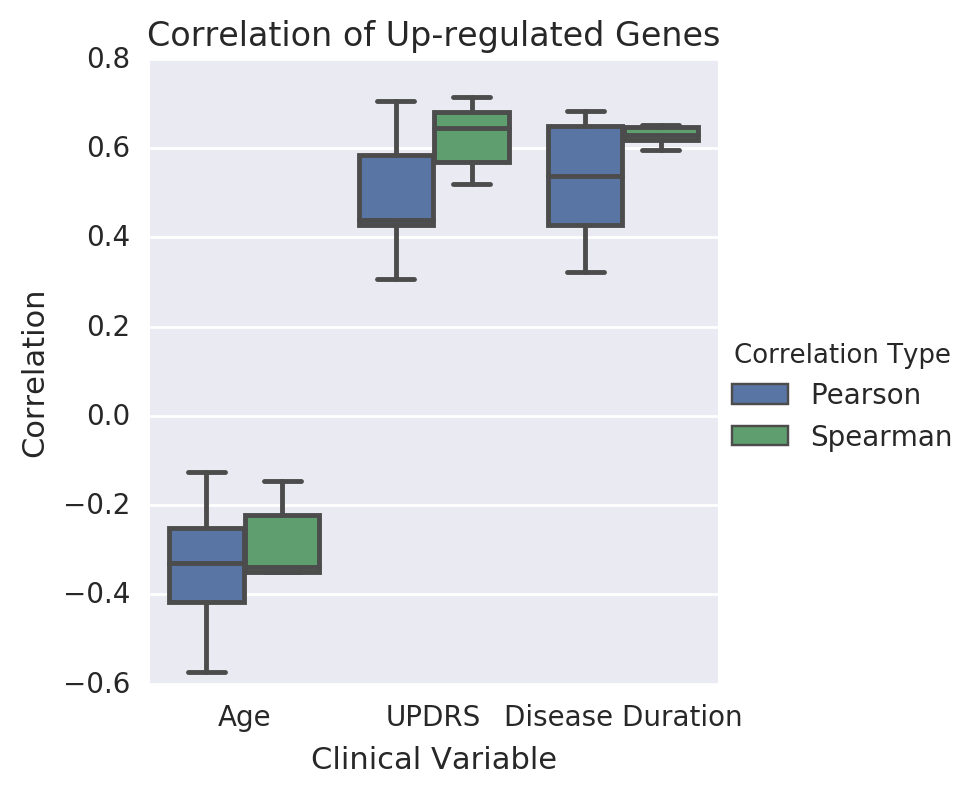

Age down median pearson: 0.24544476699 median spearman: 0.274923383104
Disease Duration down median pearson: -0.492713521127 median spearman: -0.604578989399
UPDRS down median pearson: -0.480236844972 median spearman: -0.593602074351


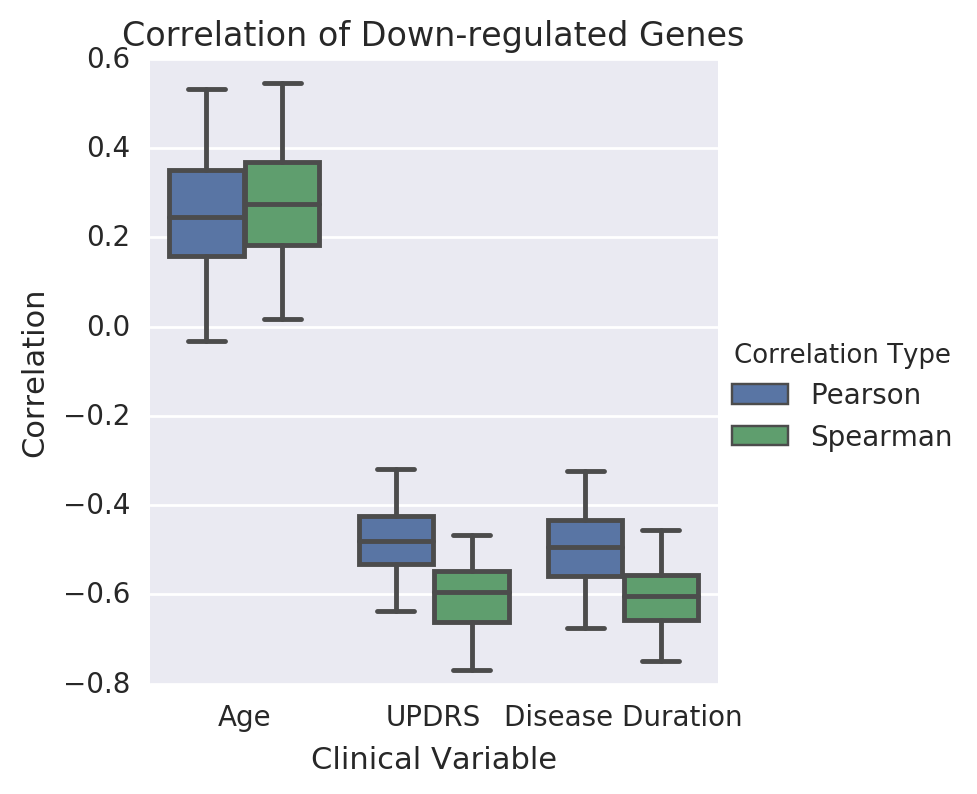

In [73]:
p_threshold = 0.01

clinical_vars = []
coefficient_types = []
coefficients = []
gene_list = stat_frame[(stat_frame['Up or Down'] == 'up') & (stat_frame['KW pval'] <p_threshold)]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
genes = []
for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
    currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
    rpkms = currentVals['rpkm'].values
    ages = currentVals['age'].values
    updrs = currentVals['updrs'].values
    duration = currentVals['duration'].values

    r_pearson,p_pearson = stats.pearsonr(rpkms, ages)
    r_spearman,p_spearman = stats.spearmanr(rpkms, ages)
    
    # age testing 
    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Age')
    clinical_vars.append('Age')


    # updrs testing
    r_pearson,p_pearson = stats.pearsonr(rpkms, updrs)
    r_spearman,p_spearman = stats.spearmanr(rpkms, updrs)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('UPDRS')
    clinical_vars.append('UPDRS')
    
    r_pearson,p_pearson = stats.pearsonr(rpkms, duration)
    r_spearman,p_spearman = stats.spearmanr(rpkms, duration)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Disease Duration')
    clinical_vars.append('Disease Duration')
    
    genes = genes + 6 * [gene]
    


correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients,
                                 'Gene':genes})
for cv in sorted(set(clinical_vars)):
    print(cv,'up', 'median pearson:', np.median(correlation_frame[(correlation_frame['Clinical Variable']==cv) &
                                                              (correlation_frame['Correlation Type']=='Pearson')
                                                             ]['Correlation']), 
          'median spearman:',np.median(correlation_frame[(correlation_frame['Clinical Variable']==cv) &
                                                              (correlation_frame['Correlation Type']=='Spearman')
                                                             ]['Correlation']))
sns.factorplot(x='Clinical Variable', 
               y='Correlation', 
               hue = 'Correlation Type', 
               data = correlation_frame, 
               kind='box', whis=1, showfliers=False, size=4)


plt.title('Correlation of Up-regulated Genes')
plt.savefig('./figures/clinical_correlation_up.pdf')
plt.show()
correlation_frame.to_csv('gene_clinical_correlation_up.tsv',sep='\t')
clinical_vars = []
coefficient_types = []
coefficients = []
# gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['EdgeR pval'] <p_threshold)]['gene']
gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['KW pval'] <p_threshold)]['gene']


gene_list = [x for x in gene_list if x in cv_genes]


genes = []
for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
    currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
    rpkms = currentVals['rpkm'].values
    ages = currentVals['age'].values
    updrs = currentVals['updrs'].values
    duration = currentVals['duration'].values

    r_pearson,p_pearson = stats.pearsonr(rpkms, ages)
    r_spearman,p_spearman = stats.spearmanr(rpkms, ages)
    
    # age testing 
    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Age')
    clinical_vars.append('Age')


    # updrs testing
    r_pearson,p_pearson = stats.pearsonr(rpkms, updrs)
    r_spearman,p_spearman = stats.spearmanr(rpkms, updrs)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('UPDRS')
    clinical_vars.append('UPDRS')
    
    r_pearson,p_pearson = stats.pearsonr(rpkms, duration)
    r_spearman,p_spearman = stats.spearmanr(rpkms, duration)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Disease Duration')
    clinical_vars.append('Disease Duration')
    
    genes = genes + 6 * [gene]
    


correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients,
                                 'Gene':genes})
for cv in sorted(set(clinical_vars)):
    print(cv,'down', 'median pearson:', np.median(correlation_frame[(correlation_frame['Clinical Variable']==cv) &
                                                              (correlation_frame['Correlation Type']=='Pearson')
                                                             ]['Correlation']), 
          'median spearman:',np.median(correlation_frame[(correlation_frame['Clinical Variable']==cv) &
                                                              (correlation_frame['Correlation Type']=='Spearman')
                                                             ]['Correlation']))

sns.factorplot(x='Clinical Variable', 
               y='Correlation', 
               hue = 'Correlation Type', 
               data = correlation_frame, 
               kind='box', whis=1, showfliers=False, size=4)
plt.title('Correlation of Down-regulated Genes')
correlation_frame.to_csv('gene_clinical_correlation_down.tsv',sep='\t')



plt.savefig('./figures/clinical_correlation_down.pdf')

## PCA Analysis

In [74]:
import sklearn

from sklearn import preprocessing

from sklearn import decomposition

from matplotlib import patches as mpatches

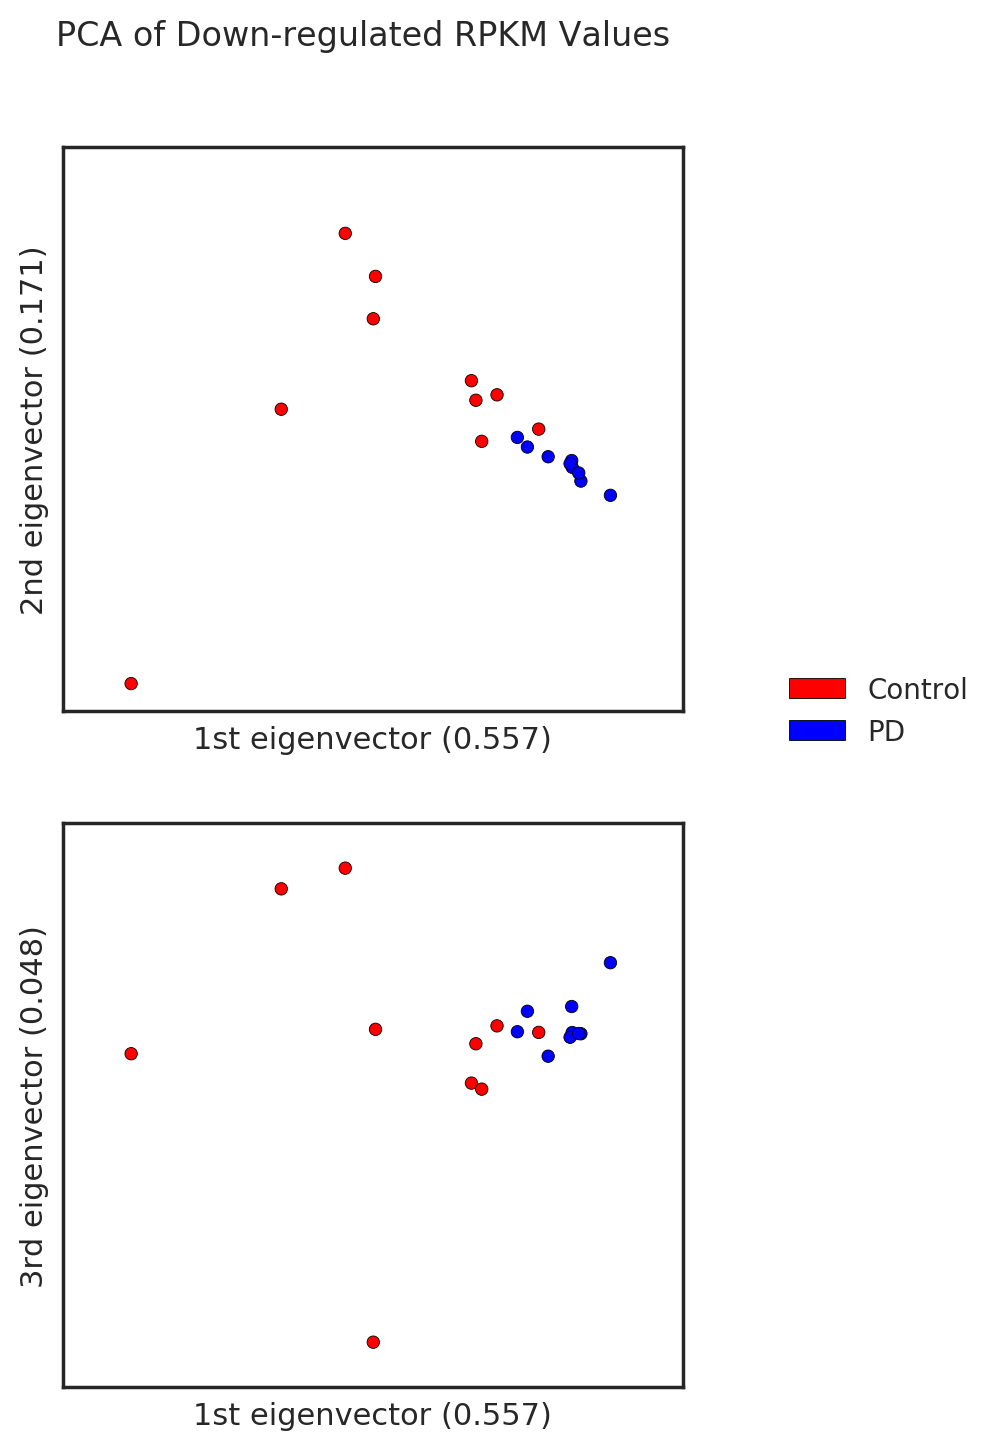

In [75]:
p_threshold = 0.01
gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['KW pval'] <p_threshold)]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
# refseq_list = [gene_refseq_mapping[x] for x in gene_list]
# features = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseq_list)]
features = idr_rpkm_frame[idr_rpkm_frame.index.isin(gene_list)]


normalized_features = pd.DataFrame(preprocessing.normalize(features,axis=1))
normalized_features.columns = features.columns
normalized_features.index = features.index

colors = ['Blue' if 'PD' in x else 'red' for x in normalized_features.columns.values]


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normalized_features.T)
explained_variance_ratios = model.explained_variance_ratio_

sns.set_style('white')
f, axs = plt.subplots(2,1, figsize=(4,8))
                
plt.suptitle('PCA of Down-regulated RPKM Values')

# 1st and 2nd principal component
plt.subplot(2,1,1)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# legend
classes = sorted(set(filtered_summary_frame['simpleTreatment'].values))
class_colours = ['red', 'blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 0))

# 1st and 3rd principal component
plt.subplot(2,1,2)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])

plt.savefig('./figures/pca_2d_down.pdf', bbox_inches='tight')
plt.show()

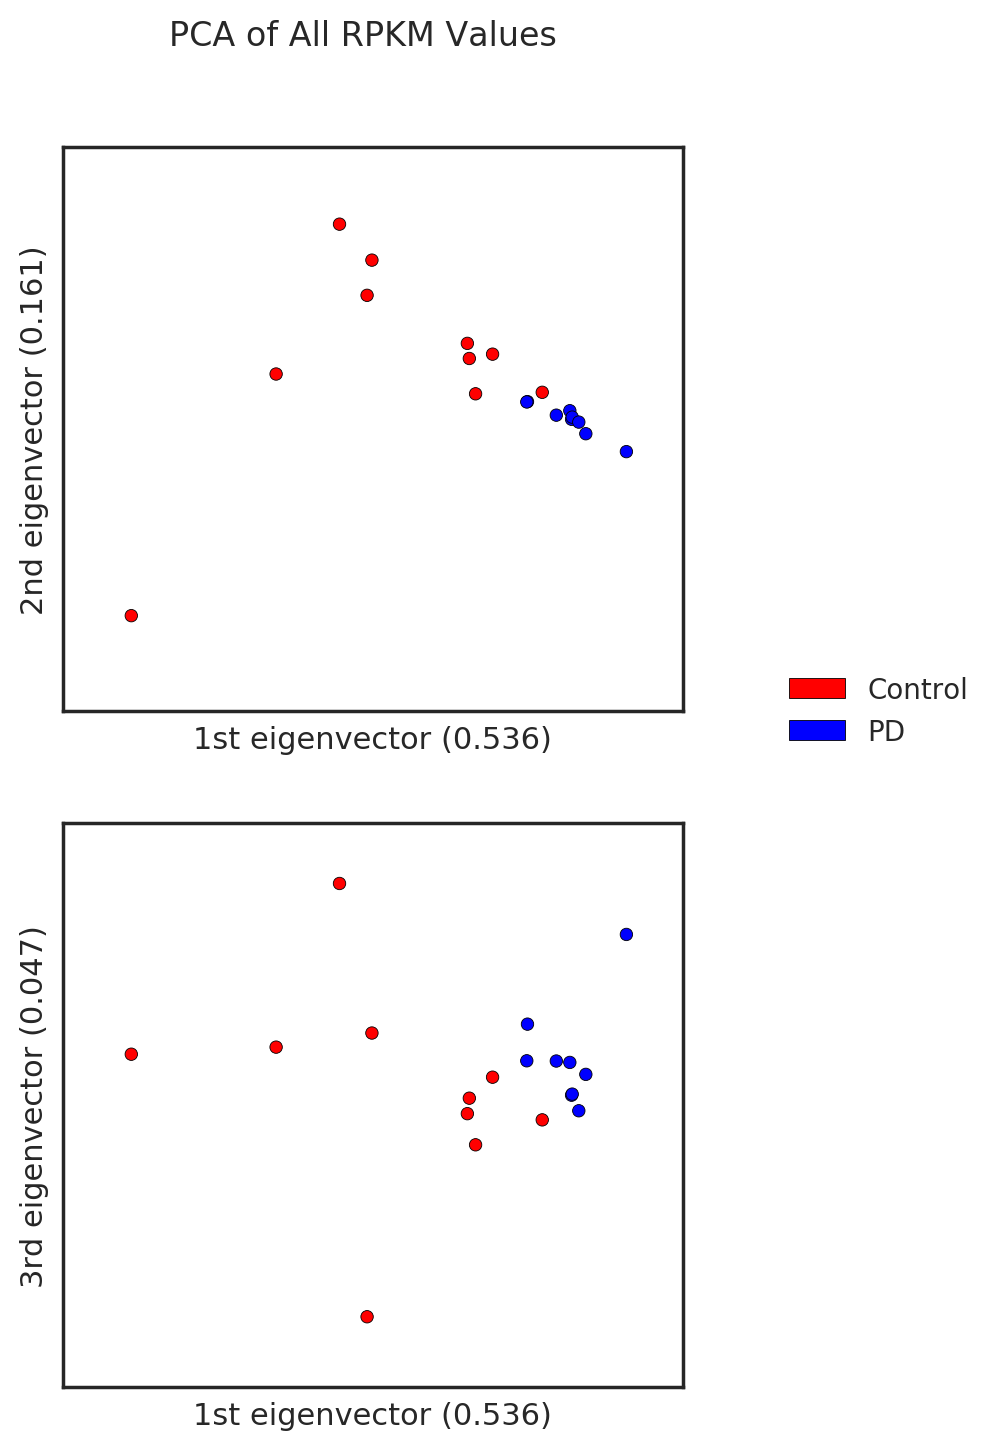

In [76]:
p_threshold = 0.01
gene_list = stat_frame[stat_frame['KW pval'] <p_threshold]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
# refseq_list = [gene_refseq_mapping[x] for x in gene_list]
# features = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseq_list)]
features = idr_rpkm_frame[idr_rpkm_frame.index.isin(gene_list)]


normalized_features = pd.DataFrame(preprocessing.normalize(features,axis=1))
normalized_features.columns = features.columns
normalized_features.index = features.index

colors = ['Blue' if 'PD' in x else 'red' for x in normalized_features.columns.values]


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normalized_features.T)
explained_variance_ratios = model.explained_variance_ratio_

sns.set_style('white')
f, axs = plt.subplots(2,1, figsize=(4,8))
                
plt.suptitle('PCA of All RPKM Values')

# 1st and 2nd principal component
plt.subplot(2,1,1)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# legend
classes = sorted(set(filtered_summary_frame['simpleTreatment'].values))
class_colours = ['red', 'blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 0))

# 1st and 3rd principal component
plt.subplot(2,1,2)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])

plt.savefig('./figures/pca_2d_all.pdf', bbox_inches='tight')
plt.show()

## Gene Ontology Analysis

In [191]:
p_threshold = 0.01
gene_list_up = stat_frame[(stat_frame['KW pval'] <p_threshold) & (stat_frame['Up or Down'] == 'up')]['gene'].values
gene_list_up = [x for x in gene_list_up if x in cv_genes]
gene_list_down = stat_frame[(stat_frame['KW pval'] <p_threshold) & (stat_frame['Up or Down'] == 'down')]['gene'].values
gene_list_down = [x for x in gene_list_down if x in cv_genes]

# write target genes file
outFile = open('go_genes_up.txt', 'w')
for g in gene_list_up:
    outFile.write(g.upper()+ '\n')
outFile.close()

outFile = open('go_genes_down.txt', 'w')
for g in gene_list_down:
    outFile.write(g.upper()+ '\n')
outFile.close()

# write background file
outFile = open('background.txt', 'w')
for g in [refseq_gene_mapping[x] for x in filtered_rpkm_frame.index.values]:
    outFile.write(g.upper() + '\n')
outFile.close()

In [96]:
os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./go_genes_up.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_up.txt')

os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./go_genes_down.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_down.txt')

# print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_up.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_up.txt')

# print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_down.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_down.txt')




256

In [ ]:
go_frame_up = pd.read_csv('go_results_up.txt',sep='\t', skiprows=2)

In [ ]:
go_frame_down = pd.read_csv('go_results_down.txt',sep='\t', skiprows=2)

In [ ]:
gene_go_dict = {}
go_gene_dict = {}
with open('/home/jenhan/analysis/go_analysis/human_association') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split('\t')
    gene = tokens[0]
    terms = tokens[1].split(';')
    gene_go_dict[gene] = terms
    for t in terms:
        if t in go_gene_dict:
            go_gene_dict[t].append(gene)
        else:
            go_gene_dict[t] = [gene]

        

In [ ]:
go_description_dict = dict(zip(go_frame_up['id'].values, go_frame_up['description'].values))
go_description_dict.update(dict(zip(go_frame_down['id'].values, go_frame_down['description'].values)))

In [ ]:
term_children_dict = {
'GO:0060563':set(['GO:0060563','GO:0061453', 'GO:0030318', 'GO:0050933', 'GO:0042491', 'GO:0050934', 'GO:0060531', 'GO:0061104', 'GO:0061102', 'GO:0061103', 'GO:0061100', 'GO:0061101', 'GO:0060129', 'GO:0071895']),
'GO:0046328':set(['GO:0046328','GO:0007256', 'GO:0046329', 'GO:0046330', 'GO:0042655', 'GO:0043508', 'GO:0007257', 'GO:0043506', 'GO:0043507']),
'GO:0030217':set(['GO:0046632', 'GO:0061470', 'GO:0002361', 'GO:0042093', 'GO:0002303', 'GO:0002302', 'GO:0002301', 'GO:0002300', 'GO:1904156', 'GO:1904157', 'GO:0001865', 'GO:0002304', 'GO:0002307', 'GO:0002308', 'GO:0043367', 'GO:0002306', 'GO:0002305', 'GO:0033077', 'GO:0033078', 'GO:1904155', 'GO:0072539', 'GO:0045066', 'GO:0045063', 'GO:0002293', 'GO:0002292', 'GO:0002294', 'GO:0045065', 'GO:0045064', 'GO:0002299', 'GO:0002298', 'GO:0042492', 'GO:0043379', 'GO:0043374']),
'GO:0042110': set(['GO:0002289', 'GO:0033080', 'GO:0046633', 'GO:0046632', 'GO:0061470', 'GO:0046630', 'GO:0042722', 'GO:0002303', 'GO:0002302', 'GO:0002301', 'GO:0002300', 'GO:1904156', 'GO:0001866', 'GO:0001865', 'GO:0002304', 'GO:0002307', 'GO:0002309', 'GO:0002308', 'GO:0043367', 'GO:1904157', 'GO:0002305', 'GO:0030217', 'GO:1904155', 'GO:0046631', 'GO:0035709', 'GO:0045063', 'GO:0045066', 'GO:0045065', 'GO:0045064', 'GO:0042492', 'GO:0043379', 'GO:0043316', 'GO:0035739', 'GO:0043374', 'GO:0046629', 'GO:0002306', 'GO:0036037', 'GO:0050798', 'GO:0042093', 'GO:0002286', 'GO:0002287', 'GO:0002288', 'GO:0042098', 'GO:0002361', 'GO:0035712', 'GO:0035741', 'GO:0035740', 'GO:0051132', 'GO:0035742', 'GO:0033077', 'GO:0033079', 'GO:0033078', 'GO:0001777', 'GO:0072539', 'GO:0002291', 'GO:0002290', 'GO:0002293', 'GO:0002292', 'GO:0002294', 'GO:0061485', 'GO:0002299', 'GO:0002298', 'GO:0002310', 'GO:0002311', 'GO:0035710', 'GO:0035711'])
                     }

In [ ]:
_genes = []
_descriptions = []

for term in term_children_dict.keys():
    genes = []
    for t in term_children_dict[term]:
        if t in go_gene_dict:
            genes = genes+ go_gene_dict[t]
    genes = sorted(set(genes))
    print('***',term, go_description_dict[term], len(genes))
    for g in genes:
        if g.upper() in cv_genes or g in cv_genes:
            print(g)
            _genes.append(g)
            _descriptions.append(go_description_dict[term])


gene_description_dict = dict(zip(_genes, _descriptions))

In [ ]:
sig_genes = _genes
go_plotting_frame = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['gene'].isin(sig_genes)]
gene_pval_dict = dict(zip(stat_frame['gene'].values, stat_frame['KW pval'].values))
go_plotting_frame['Term'] = [gene_description_dict[x] for x in go_plotting_frame['gene']]
go_plotting_frame['p-value']=[gene_pval_dict[x] for x in go_plotting_frame['gene']]
go_plotting_frame.columns = ['Gene', 'Refseq', 'RPKM', 'Sample Name', 'Group', 'Term', 'p-value']

In [ ]:
! if [ ! -d ./bar_plots ]; then mkdir ./bar_plots; fi
for term in sorted(set(go_plotting_frame['Term'].values)):
    sns.factorplot(data = go_plotting_frame[go_plotting_frame['Term']==term].sort('p-value'), 
                   x='Gene', 
                   y='RPKM', 
                   hue = 'Group', 
                   kind='bar',
                   hue_order = ['Control', 'PD'],
                   size=10)
    plt.title(term)
    plt.savefig('./bar_plots/'+'_'.join(term.split())+'.pdf')
    plt.show()
sns.factorplot(data = go_plotting_frame[go_plotting_frame['Gene'].isin(['NCOR1','RC3H1','ZFP36L2'])], 
              x='Gene', 
                   y='RPKM', 
                   hue = 'Group', 
                   kind='bar',
                   hue_order = ['Control', 'PD'],
                   size=10)
plt.title('T cell differentiation')
plt.savefig('./bar_plots/'+'_'.join('T cell differentiation'.split())+'.pdf')



In [ ]:
data = data=go_plotting_frame

gene_foldChange_dict = dict(zip(stat_frame['gene'], stat_frame['fold change']))
data['fold change'] = [gene_foldChange_dict[x] for x in data['Gene']]

In [ ]:
sns.factorplot(x='Gene', 
               y='RPKM', 
               kind='bar',
               data=data, 
               hue='Group',
              size=10)
plt.savefig('bar_plot_all.pdf')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


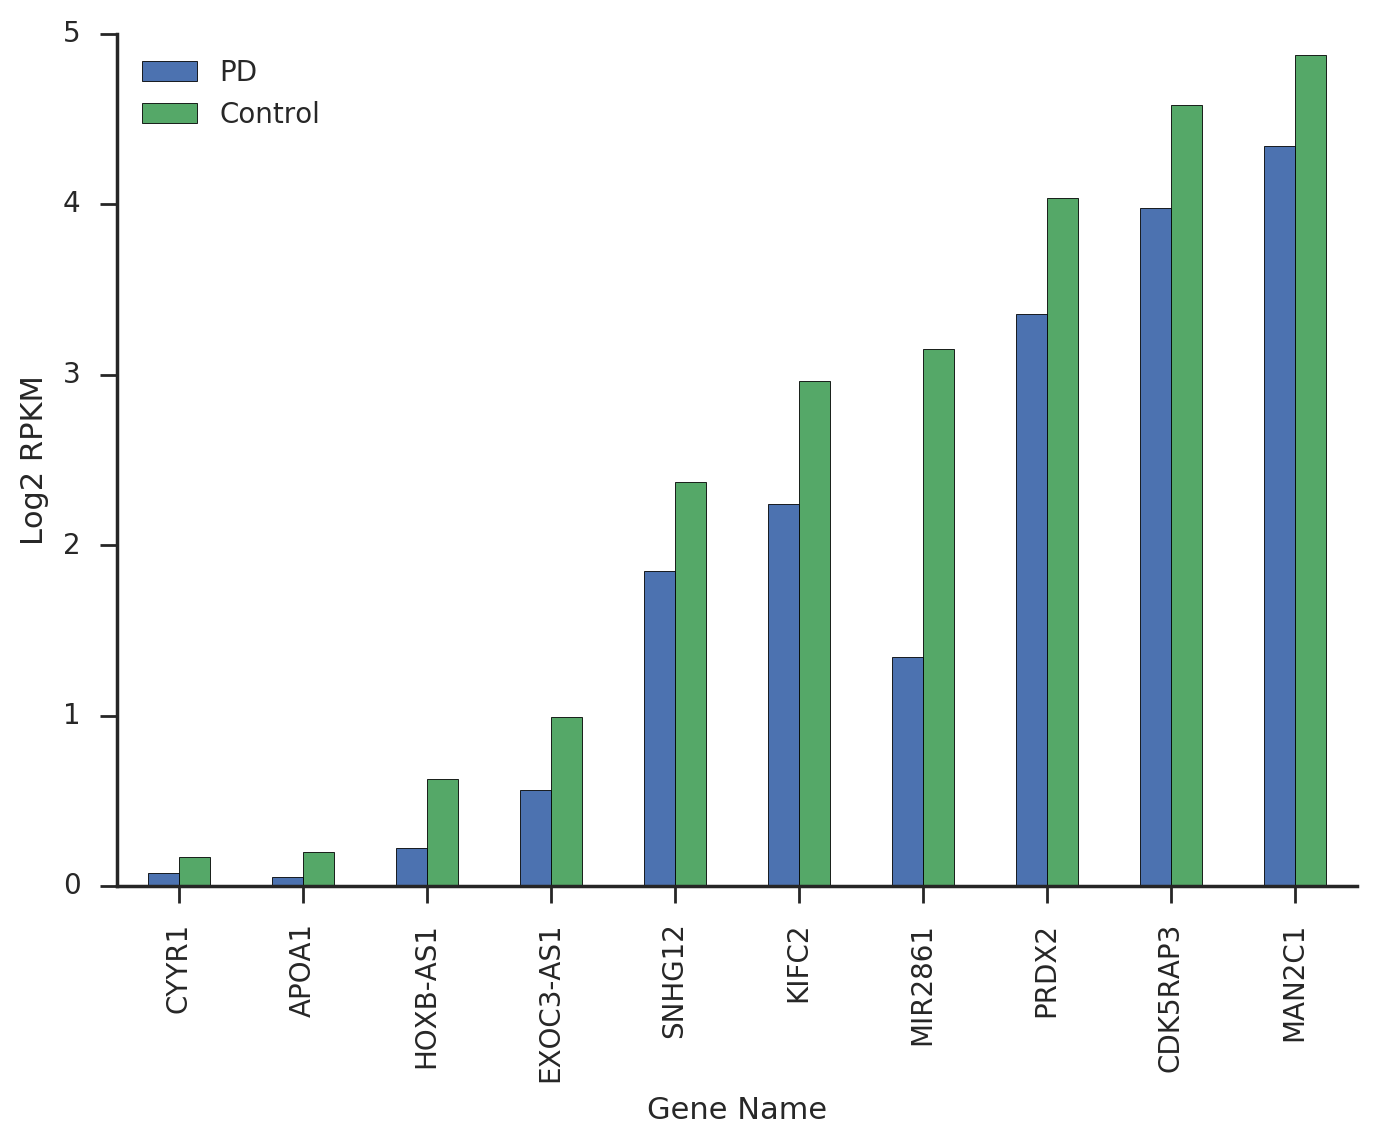

In [86]:
data = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(cv_genes)]
logged_data = np.log2(data+1)
logged_data = logged_data.sort('Control')
with sns.axes_style('ticks', {'axes.grid':False, 'grid.color':'white'}):
    logged_data.plot(kind='bar', sort_columns=True)
    sns.despine()
    plt.ylabel('Log2 RPKM')
    plt.xlabel('Gene Name')
plt.savefig('./figures/allGenes_barplot.pdf',bbox_inches='tight')

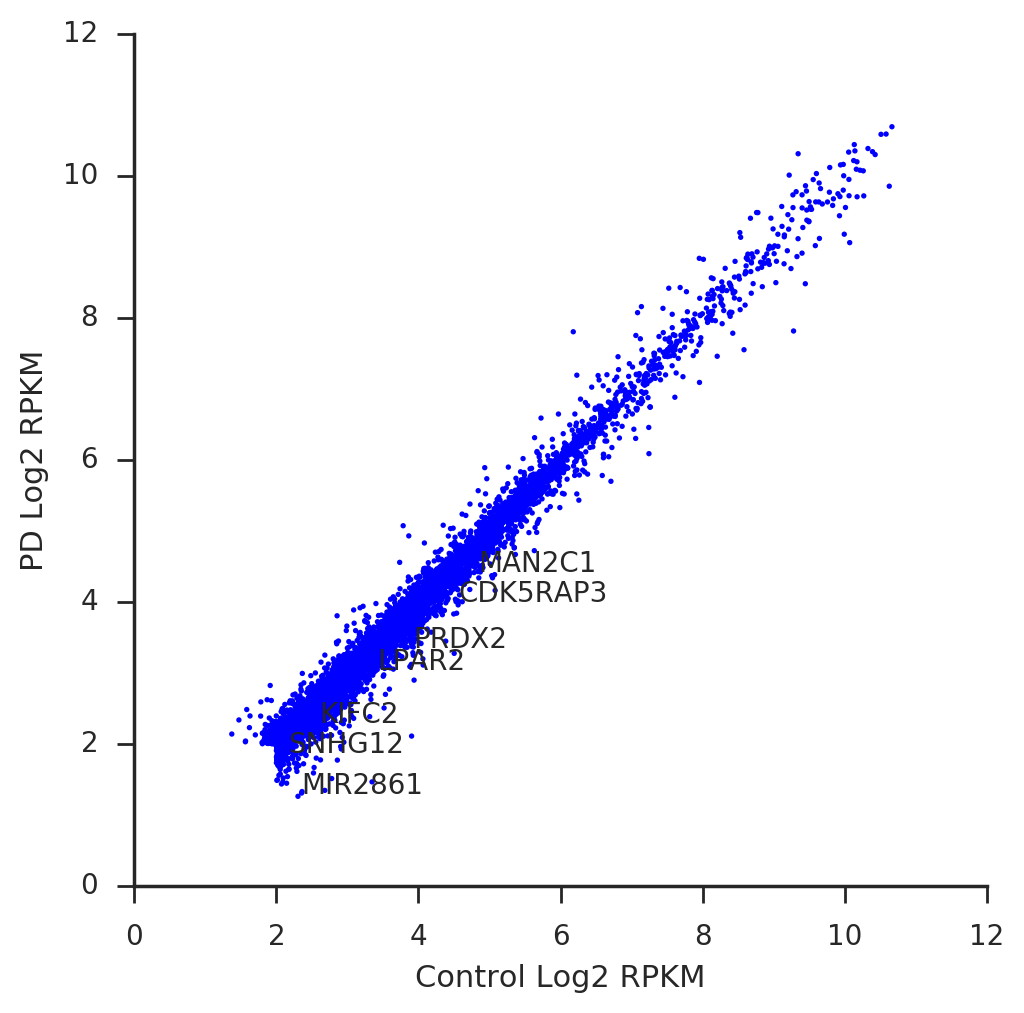

In [187]:
reads1 = np.log2(idr_rpkm_median_frame['Control']+1)
reads2 = np.log2(idr_rpkm_median_frame['PD']+1)
names = idr_rpkm_median_frame.index.values

# reads1 = np.log2(idr_rpkm_mean_frame['Control']+1)
# reads2 = np.log2(idr_rpkm_mean_frame['PD']+1)
# names = idr_rpkm_mean_frame.index.values

tuples = zip(reads1, reads2, names)
filtered_tuples = [x for x in tuples if x[0] >=2 or x[1]>=2]

filtered_reads1 = [x[0] for x in filtered_tuples]
filtered_reads2 = [x[1] for x in filtered_tuples]

with sns.axes_style('ticks'):
    plt.scatter(filtered_reads1, filtered_reads2,
                marker = '.', s=15,
               c='blue',
               edgecolors='none', )
    for x, y, label in filtered_tuples:
        fold = x/y
    #     if fold >= 1.3 or fold <=1/1.3:
        if label in cv_genes:
            plt.annotate(label, size=10, xy=(x,y))

    ax = plt.gca()
    ax.set_xlim((0,12))
    ax.set_ylim((0,12))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    plt.xlabel('Control Log2 RPKM')
    plt.ylabel('PD Log2 RPKM')
    sns.despine()
    plt.savefig('./figures/scatterplot_annotated.pdf',bbox_inches='tight')